# Supervised learning with time-series data - pump sensors failure prediction

In [1]:
# basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data Science
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# models:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# plotting
plt.style.use("dark_background")

#### Check the raw data

In [2]:
df = pd.read_csv('data/pump_sensor.csv')
df

Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0                0  2018-04-01 00:00:00   2.465394   47.09201  53.211800   
1                1  2018-04-01 00:01:00   2.465394   47.09201  53.211800   
2                2  2018-04-01 00:02:00   2.444734   47.35243  53.211800   
3                3  2018-04-01 00:03:00   2.460474   47.09201  53.168400   
4                4  2018-04-01 00:04:00   2.445718   47.13541  53.211800   
...            ...                  ...        ...        ...        ...   
220315      220315  2018-08-31 23:55:00   2.407350   47.69965  50.520830   
220316      220316  2018-08-31 23:56:00   2.400463   47.69965  50.564240   
220317      220317  2018-08-31 23:57:00   2.396528   47.69965  50.520830   
220318      220318  2018-08-31 23:58:00   2.406366   47.69965  50.520832   
220319      220319  2018-08-31 23:59:00   2.396528   47.69965  50.520832   

        sensor_03   sensor_04  sensor_05  sensor_06  sensor_07  ...  \
0       46.310760  634.375000   76.45975   13.41146   16.13136  ...   
1       46.310760  634.375000   76.45975   13.41146   16.13136  ...   
2       46.397570  638.888900   73.54598   13.32465   16.03733  ...   
3       46.397568  628.125000   76.98898   13.31742   16.24711  ...   
4       46.397568  636.458300   76.58897   13.35359   16.21094  ...   
...           ...         ...        ...        ...        ...  ...   
220315  43.142361  634.722229   64.59095   15.11863   16.65220  ...   
220316  43.142361  630.902771   65.83363   15.15480   16.70284  ...   
220317  43.142361  625.925903   67.29445   15.08970   16.70284  ...   
220318  43.142361  635.648100   65.09175   15.11863   16.56539  ...   
220319  43.142361  639.814800   65.45634   15.11863   16.65220  ...   

        sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  \
0        41.92708  39.641200   65.68287   50.92593  38.194440   157.9861   
1        41.92708  39.641200   65.68287   50.92593  38.194440   157.9861   
2        41.66666  39.351852   65.39352   51.21528  38.194443   155.9606   
3        40.88541  39.062500   64.81481   51.21528  38.194440   155.9606   
4        41.40625  38.773150   65.10416   51.79398  38.773150   158.2755   
...           ...        ...        ...        ...        ...        ...   
220315   38.28125  68.287030   52.37268   48.32176  41.087960   212.3843   
220316   38.28125  66.840280   50.63657   48.03241  40.798610   213.8310   
220317   39.06250  65.393520   48.90046   48.03241  40.798610   217.3032   
220318   40.62500  64.236110   47.74306   48.32176  40.509258   222.5116   
220319   41.40625  62.789350   46.29630   48.90046  40.219910   227.4306   

        sensor_49  sensor_50  sensor_51  machine_status  
0        67.70834   243.0556   201.3889          NORMAL  
1        67.70834   243.0556   201.3889          NORMAL  
2        67.12963   241.3194   203.7037          NORMAL  
3        66.84028   240.4514   203.1250          NORMAL  
4        66.55093   242.1875   201.3889          NORMAL  
...           ...        ...        ...             ...  
220315  153.64580        NaN   231.1921          NORMAL  
220316  156.25000        NaN   231.1921          NORMAL  
220317  155.38190        NaN   232.0602          NORMAL  
220318  153.93520        NaN   234.0856          NORMAL  
220319  150.46300        NaN   234.0856          NORMAL  

[220320 rows x 55 columns]

- Looks like we have a time series for 5 months measured every minute - too short time-frame to consider seasonality.
- Numerical sensor data
- Categorical target variable
- Some missing values

# Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

- The data is mainly numerical, except the target variable with categorical values. <br>
- All data from Sensor 15 is missing - can be dropped. This sensor should be checked on-site immediately. <br>
- First column "Unnamed: 0" contains only the index - can be dropped, because it is redundant.

In [4]:
drop_cols = ['sensor_15', 'Unnamed: 0', 'timestamp']
df.drop(drop_cols, axis=1, inplace=True)

In [5]:
df.describe().transpose()

count        mean         std        min         25%  \
sensor_00  210112.0    2.372221    0.412227   0.000000    2.438831   
sensor_01  219951.0   47.591611    3.296666   0.000000   46.310760   
sensor_02  220301.0   50.867392    3.666820  33.159720   50.390620   
sensor_03  220301.0   43.752481    2.418887  31.640620   42.838539   
sensor_04  220301.0  590.673936  144.023912   2.798032  626.620400   
sensor_05  220301.0   73.396414   17.298247   0.000000   69.976260   
sensor_06  215522.0   13.501537    2.163736   0.014468   13.346350   
sensor_07  214869.0   15.843152    2.201155   0.000000   15.907120   
sensor_08  215213.0   15.200721    2.037390   0.028935   15.183740   
sensor_09  215725.0   14.799210    2.091963   0.000000   15.053530   
sensor_10  220301.0   41.470339   12.093519   0.000000   40.705260   
sensor_11  220301.0   41.918319   13.056425   0.000000   38.856420   
sensor_12  220301.0   29.136975   10.113935   0.000000   28.686810   
sensor_13  220301.0    7.078858    6.901755   0.000000    1.538516   
sensor_14  220299.0  376.860041  113.206382  32.409550  418.103250   
sensor_16  220289.0  416.472892  126.072642   0.000000  459.453400   
sensor_17  220274.0  421.127517  129.156175   0.000000  454.138825   
sensor_18  220274.0    2.303785    0.765883   0.000000    2.447542   
sensor_19  220304.0  590.829775  199.345820   0.000000  662.768975   
sensor_20  220304.0  360.805165  101.974118   0.000000  398.021500   
sensor_21  220304.0  796.225942  226.679317  95.527660  875.464400   
sensor_22  220279.0  459.792815  154.528337   0.000000  478.962600   
sensor_23  220304.0  922.609264  291.835280   0.000000  950.922400   
sensor_24  220304.0  556.235397  182.297979   0.000000  601.151050   
sensor_25  220284.0  649.144799  220.865166   0.000000  693.957800   
sensor_26  220300.0  786.411781  246.663608  43.154790  790.489575   
sensor_27  220304.0  501.506589  169.823173   0.000000  448.297950   
sensor_28  220304.0  851.690339  313.074032   4.319347  782.682625   
sensor_29  220248.0  576.195305  225.764091   0.636574  518.947225   
sensor_30  220059.0  614.596442  195.726872   0.000000  627.777800   
sensor_31  220304.0  863.323100  283.544760  23.958330  839.062400   
sensor_32  220252.0  804.283915  260.602361   0.240716  760.607475   
sensor_33  220304.0  486.405980  150.751836   6.460602  489.761075   
sensor_34  220304.0  234.971776   88.376065  54.882370  172.486300   
sensor_35  220304.0  427.129817  141.772519   0.000000  353.176625   
sensor_36  220304.0  593.033876  289.385511   2.260970  288.547575   
sensor_37  220304.0   60.787360   37.604883   0.000000   28.799220   
sensor_38  220293.0   49.655946   10.540397  24.479166   45.572910   
sensor_39  220293.0   36.610444   15.613723  19.270830   32.552080   
sensor_40  220293.0   68.844530   21.371139  23.437500   57.812500   
sensor_41  220293.0   35.365126    7.898665  20.833330   32.552080   
sensor_42  220293.0   35.453455   10.259521  22.135416   32.812500   
sensor_43  220293.0   43.879591   11.044404  24.479166   39.583330   
sensor_44  220293.0   42.656877   11.576355  25.752316   36.747684   
sensor_45  220293.0   43.094984   12.837520  26.331018   36.747684   
sensor_46  220293.0   48.018585   15.641284  26.331018   40.509258   
sensor_47  220293.0   44.340903   10.442437  27.199070   39.062500   
sensor_48  220293.0  150.889044   82.244957  26.331018   83.912030   
sensor_49  220293.0   57.119968   19.143598  26.620370   47.743060   
sensor_50  143303.0  183.049260   65.258650  27.488426  167.534700   
sensor_51  204937.0  202.699667  109.588607  27.777779  179.108800   

                  50%          75%          max  
sensor_00    2.456539     2.499826     2.549016  
sensor_01   48.133678    49.479160    56.727430  
sensor_02   51.649300    52.777770    56.032990  
sensor_03   44.227428    45.312500    48.220490  
sensor_04  632.638916   637.615723   800.000000  
sensor_05   75.576790    80.912150    99.999880  
sensor_06   13.642940  

#### Missing data check

In [6]:
missing_dict = dict()

# summarize the number of rows with missing values for each column
for column in df.columns:
    # count number of rows with missing values
    n_miss = df[column].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    # append to dict
    missing_dict[column] = [n_miss, perc.round(2)]

missing_df = pd.DataFrame(missing_dict.values(),
                          index=missing_dict.keys(),
                          columns=['N_Missing [-]', 'Percentage [%]'])
missing_df

N_Missing [-]  Percentage [%]
sensor_00               10208            4.63
sensor_01                 369            0.17
sensor_02                  19            0.01
sensor_03                  19            0.01
sensor_04                  19            0.01
sensor_05                  19            0.01
sensor_06                4798            2.18
sensor_07                5451            2.47
sensor_08                5107            2.32
sensor_09                4595            2.09
sensor_10                  19            0.01
sensor_11                  19            0.01
sensor_12                  19            0.01
sensor_13                  19            0.01
sensor_14                  21            0.01
sensor_16                  31            0.01
sensor_17                  46            0.02
sensor_18                  46            0.02
sensor_19                  16            0.01
sensor_20                  16            0.01
sensor_21                  16            0.01
sensor_22                  41            0.02
sensor_23                  16            0.01
sensor_24                  16            0.01
sensor_25                  36            0.02
sensor_26                  20            0.01
sensor_27                  16            0.01
sensor_28                  16            0.01
sensor_29                  72            0.03
sensor_30                 261            0.12
sensor_31                  16            0.01
sensor_32                  68            0.03
sensor_33                  16            0.01
sensor_34                  16            0.01
sensor_35                  16            0.01
sensor_36                  16            0.01
sensor_37                  16            0.01
sensor_38                  27            0.01
sensor_39                  27            0.01
sensor_40                  27            0.01
sensor_41                  27            0.01
sensor_42                  27            0.01
sensor_43                  27            0.01
sensor_44                  27            0.01
sensor_45                  27            0.01
sensor_46                  27            0.01
sensor_47                  27            0.01
sensor_48                  27            0.01
sensor_49                  27            0.01
sensor_50               77017           34.96
sensor_51               15383            6.98
machine_status              0            0.00

#### Considered for dropping (>0.2% missing)

In [7]:
for key, value in missing_dict.items():
    if value[1] > 0.2:
        print(key, value[1])

sensor_00 4.63
sensor_06 2.18
sensor_07 2.47
sensor_08 2.32
sensor_09 2.09
sensor_50 34.96
sensor_51 6.98


Overall good availability of the data. <br>
- Sensor 50 can stay if there is value in it - e.g. strong corelation with the target variable. <br>
It could be dropped if there is a very strong correlation with other sensor(s) and similar information is available in the model. <br>
- Sensor 51 could be removed if correlation with target is weak. 

There are many types of interpolations available, e.g.: Linear, Spline, Stineman. <br>
KNN would be possible to use, but it is more applicable to static data, instead of time-series. It is also more computationally-demanding. <br>
Other, simpler methods, like mean, median, mode, last/next value can be considered to save time.

#### Recovery rows, broken states and missing values

- <span style="color: red;"> Red: broken state </span>
- <span style="color: orange;"> Orange: recovery mode </span>
- <span style="color: green;"> Green: missing data </span>

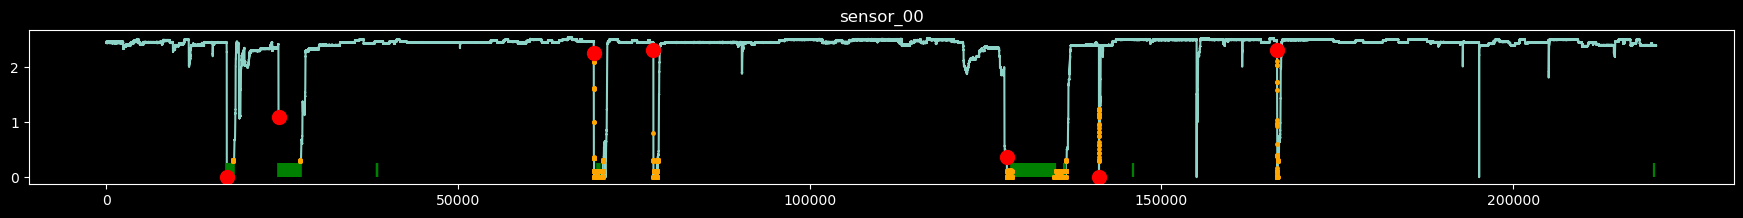

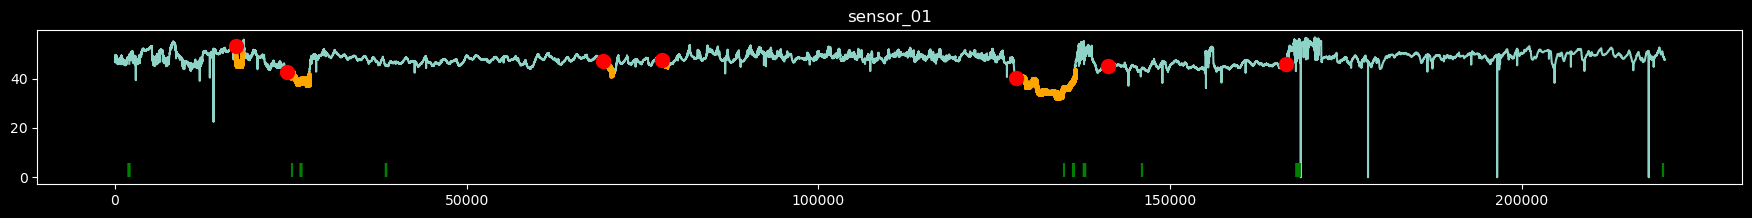

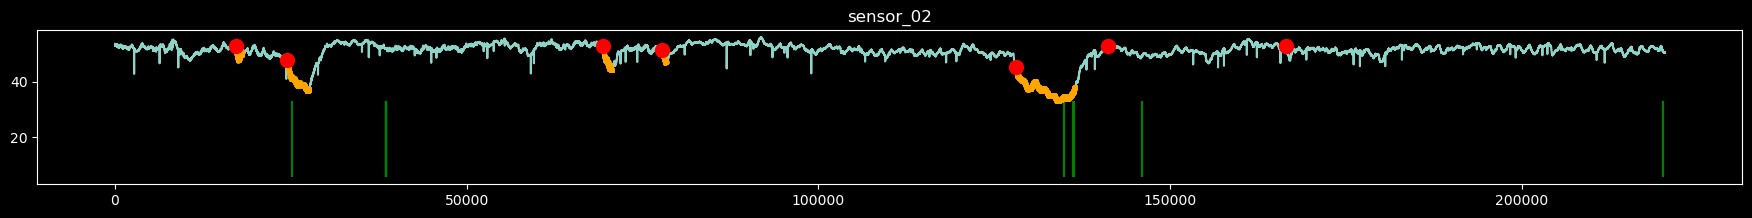

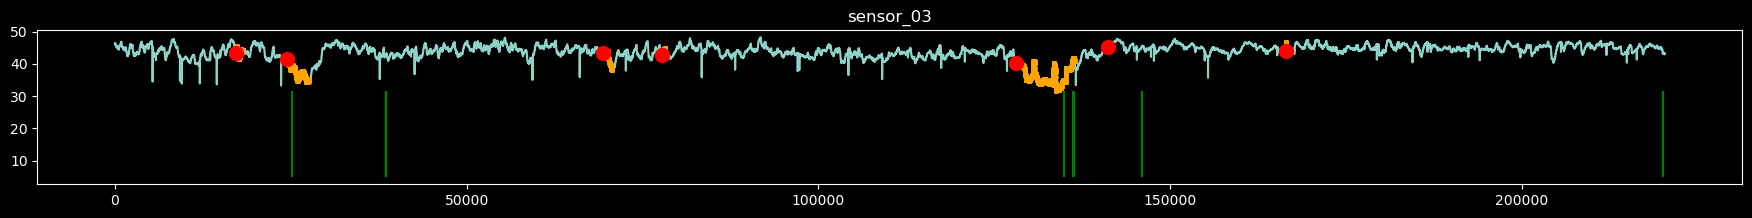

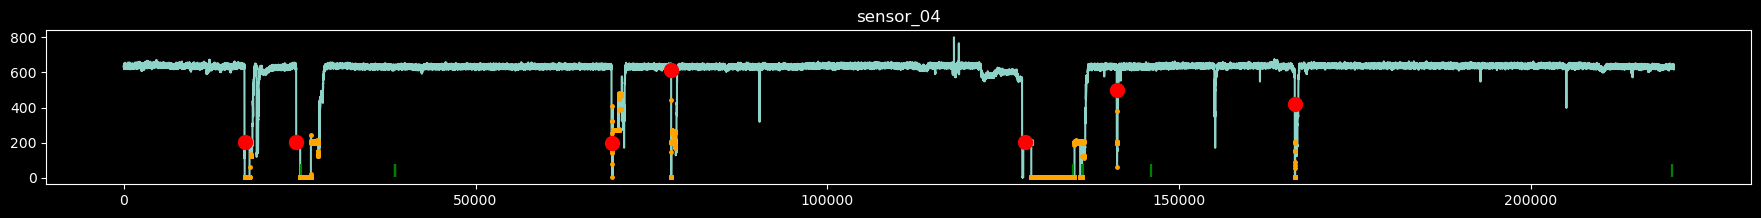

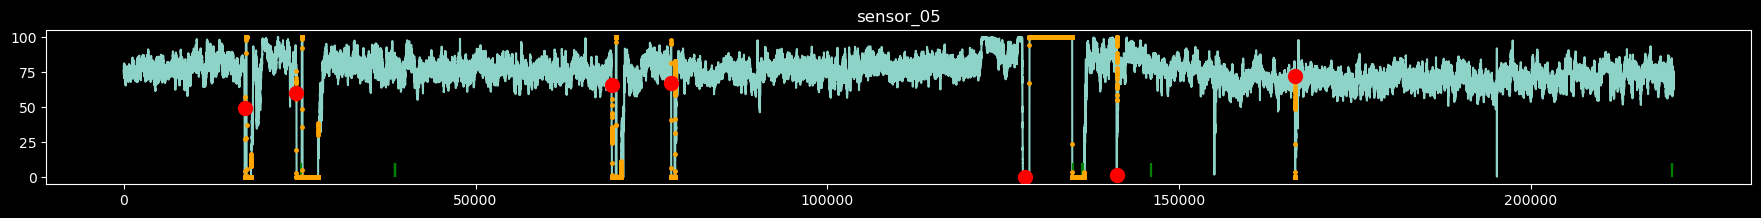

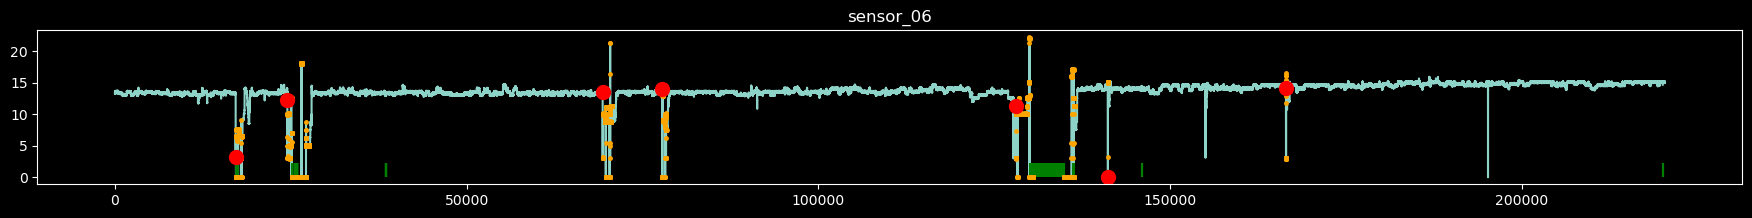

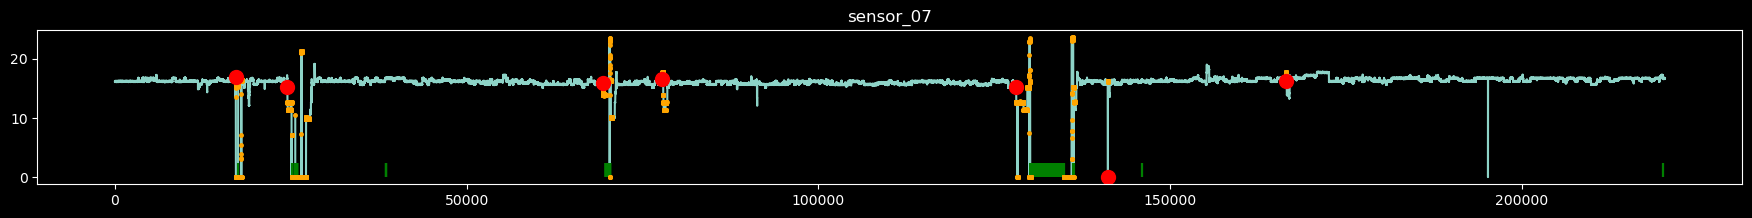

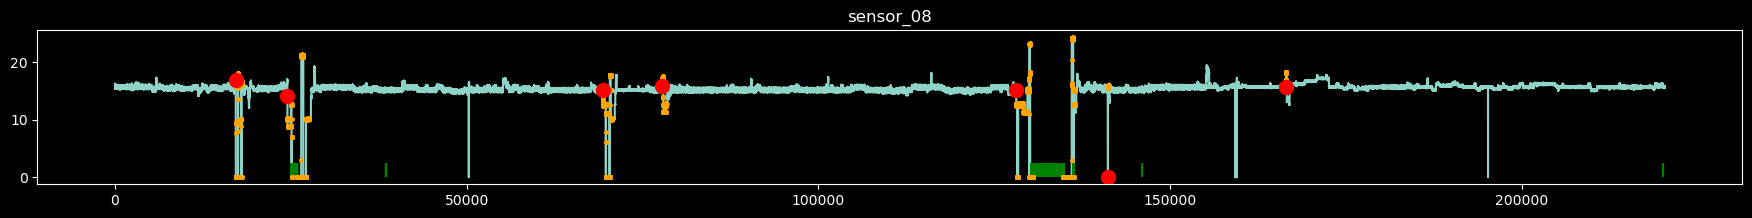

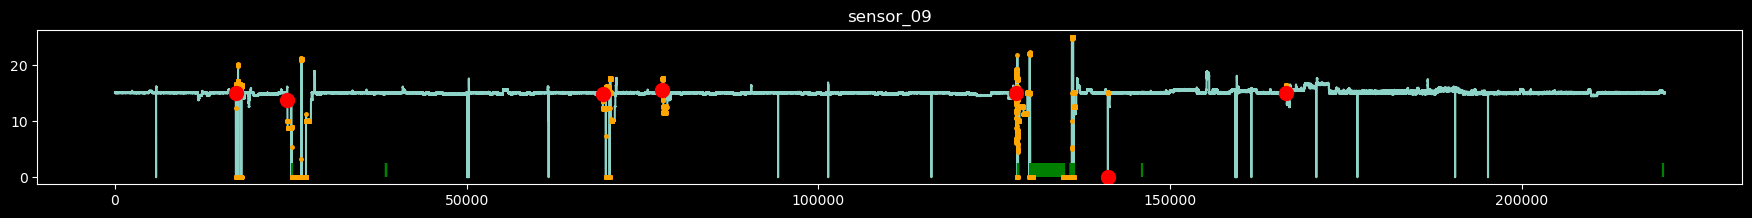

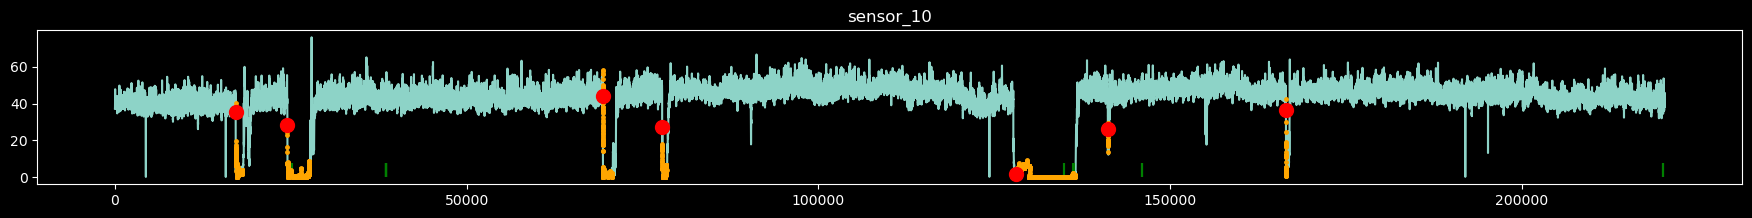

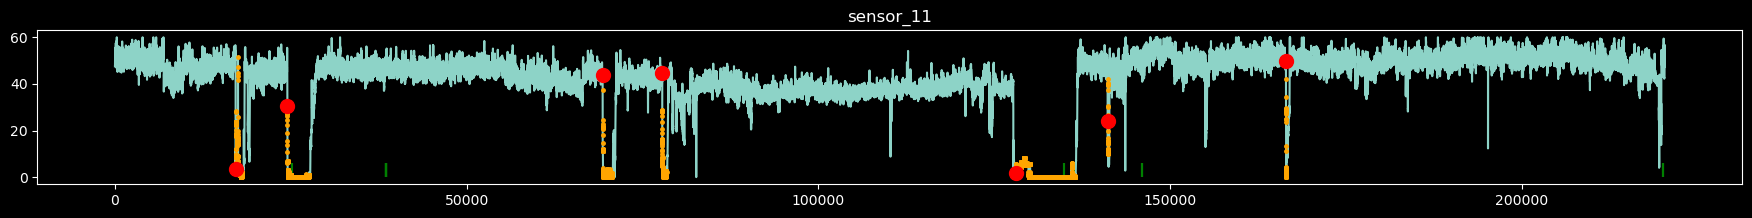

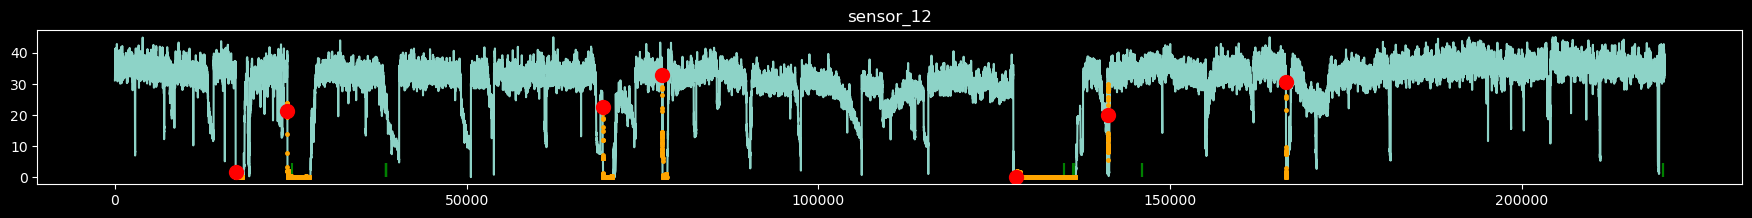

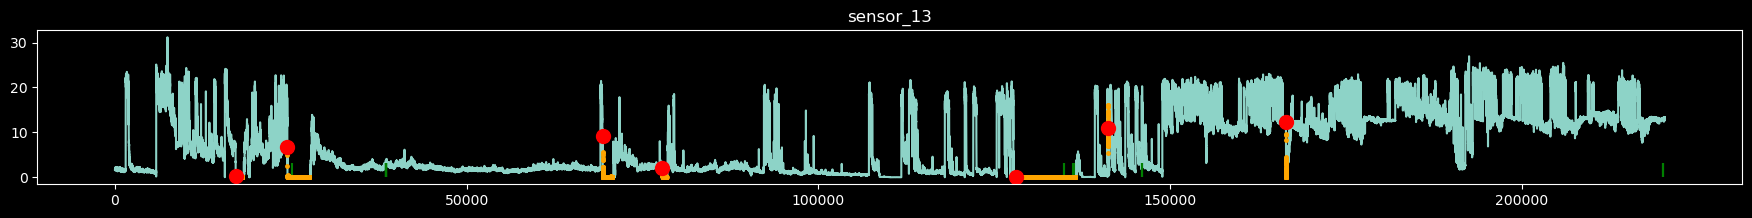

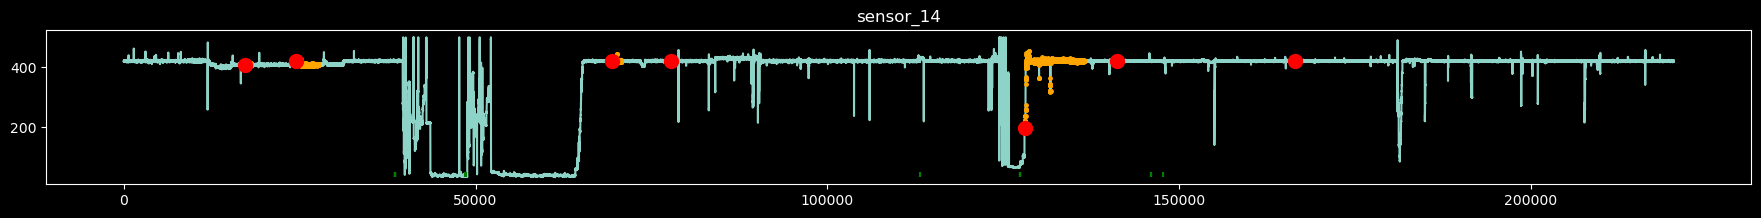

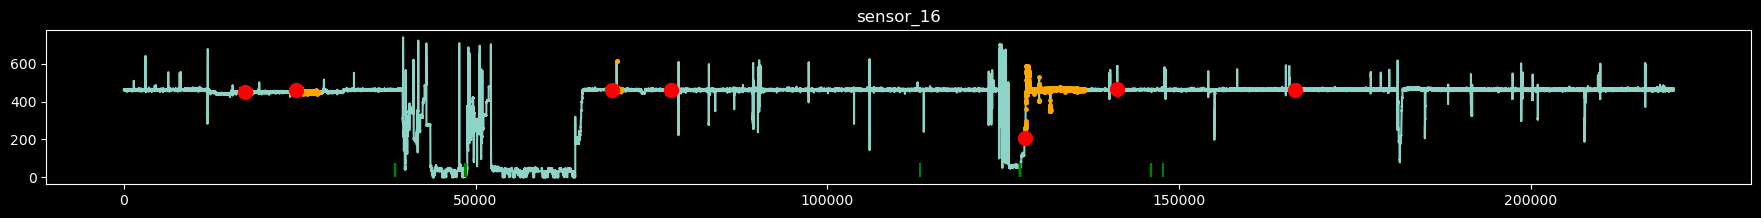

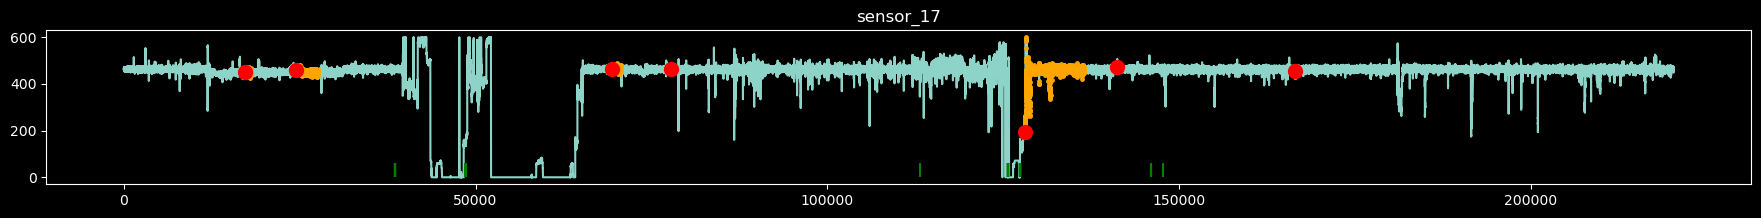

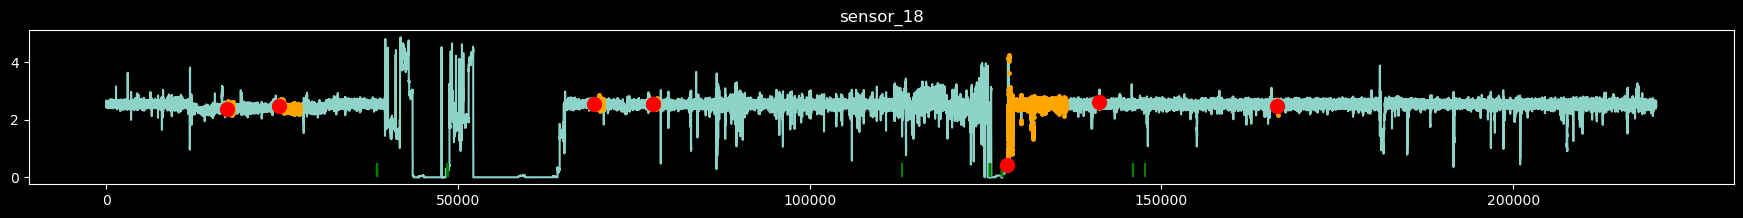

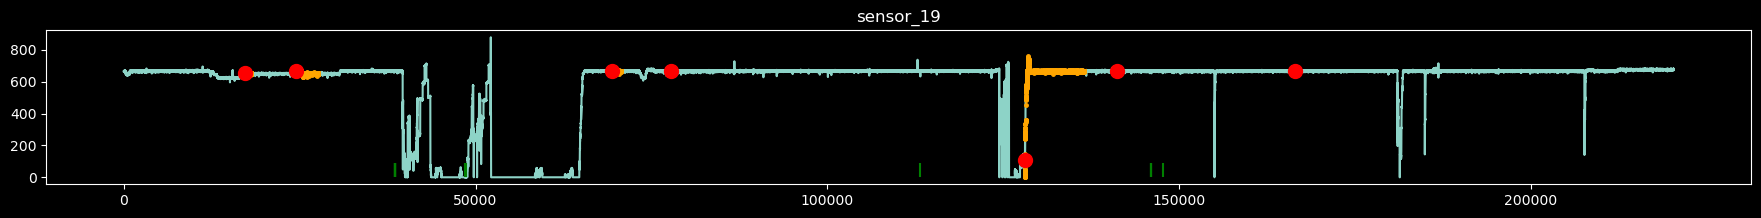

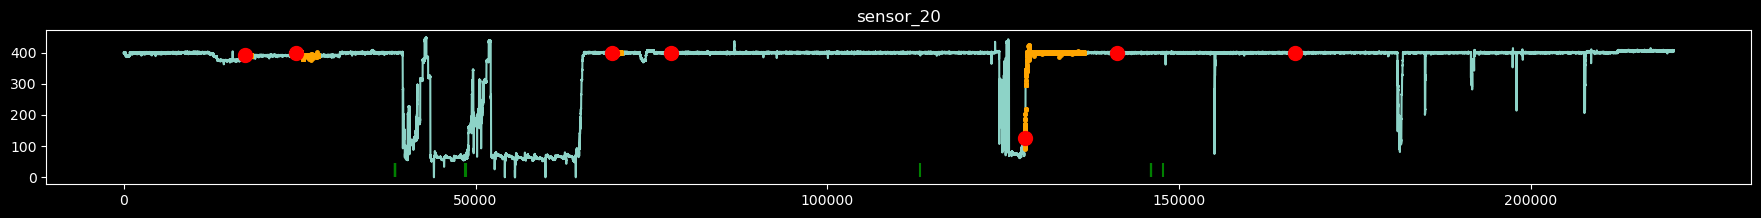

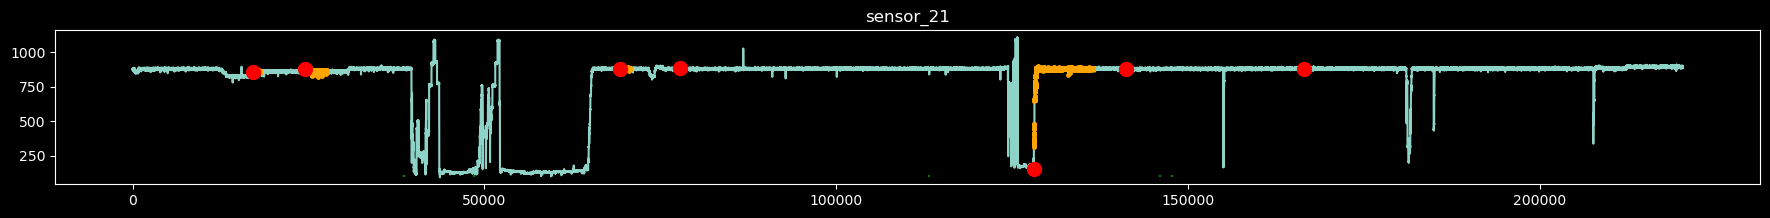

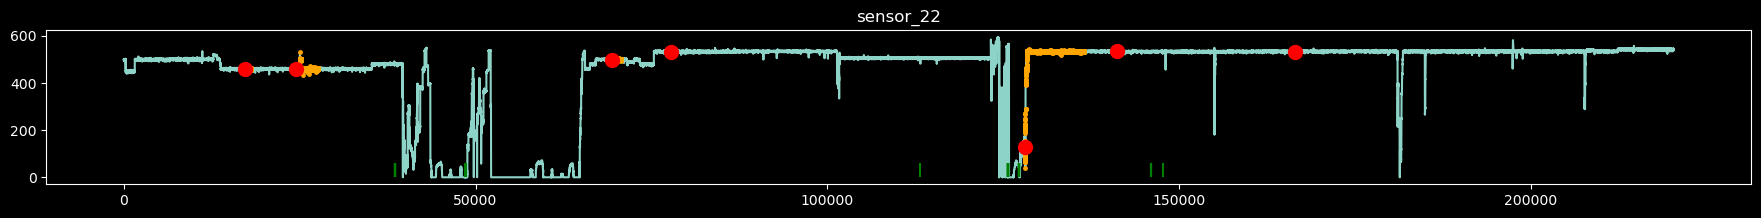

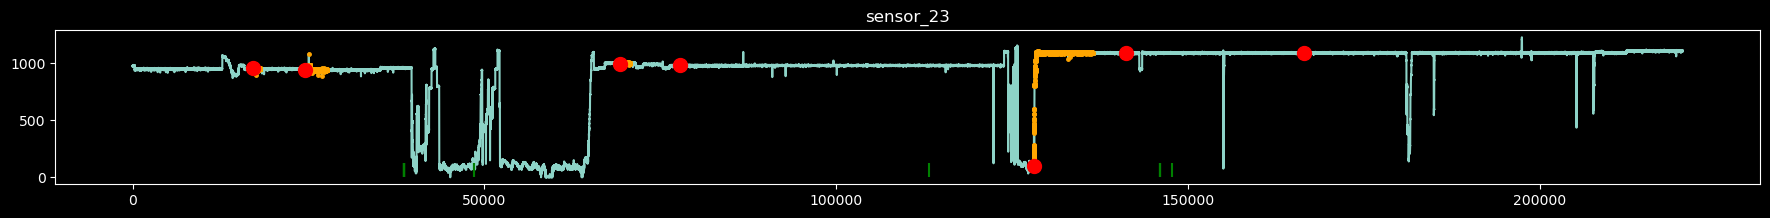

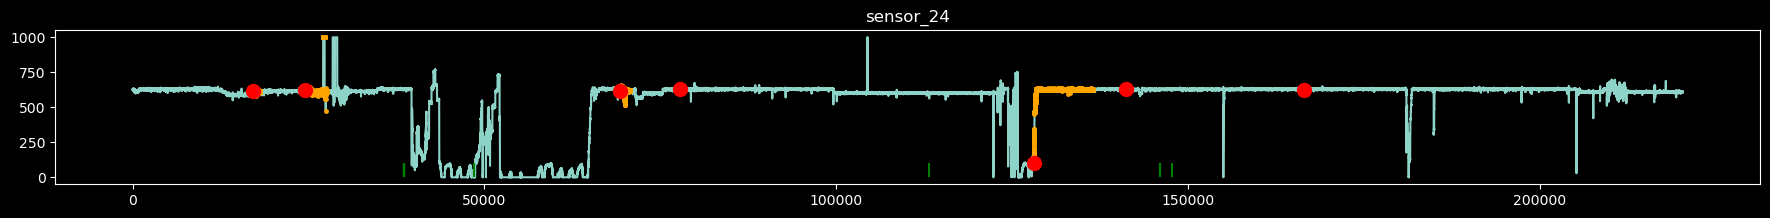

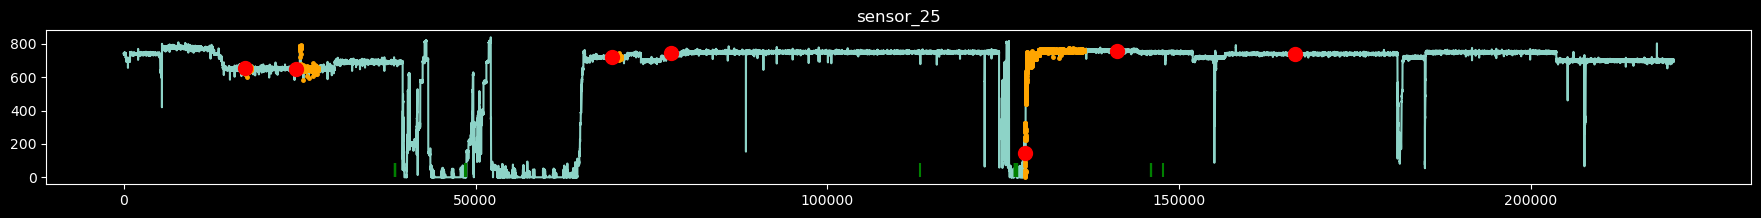

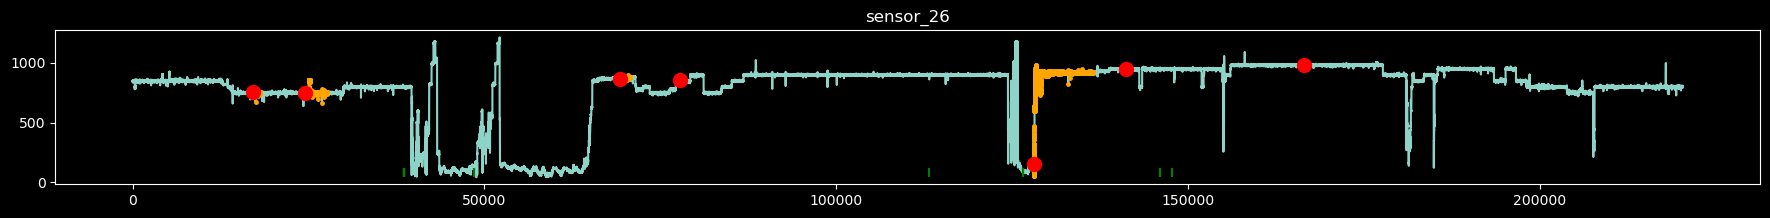

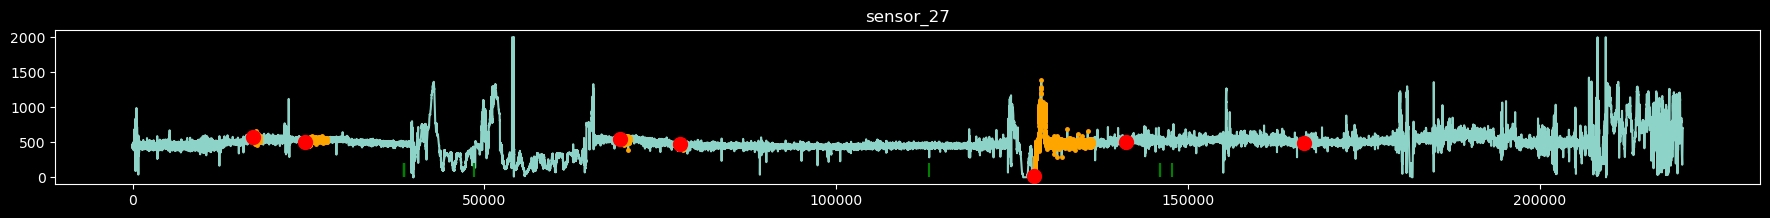

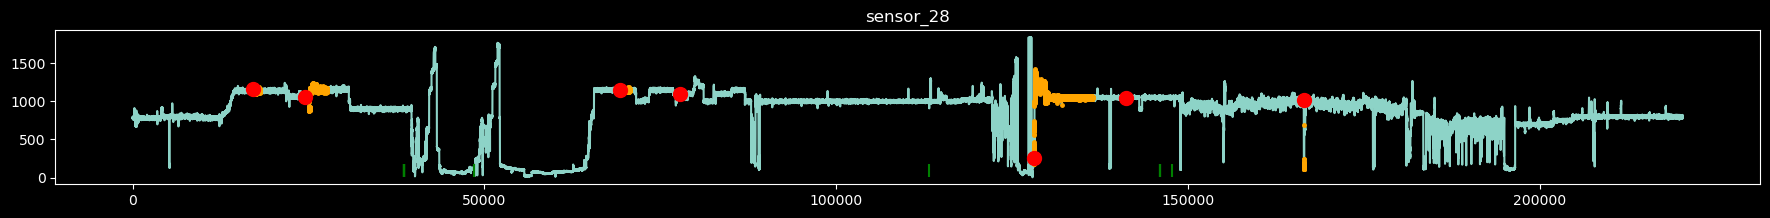

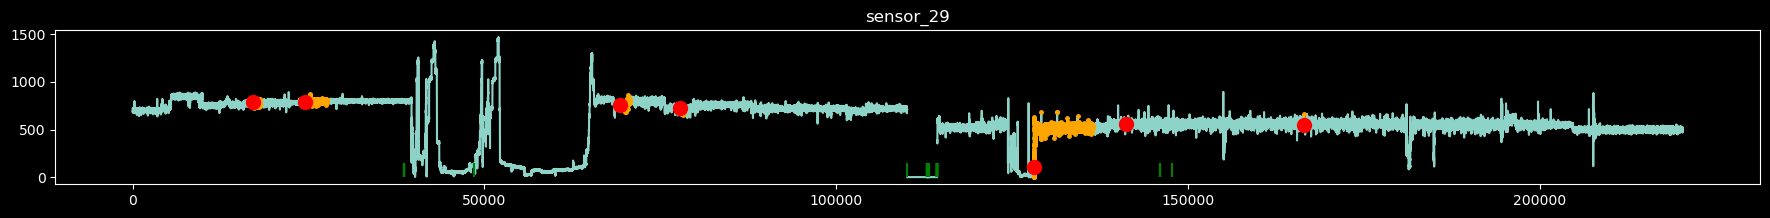

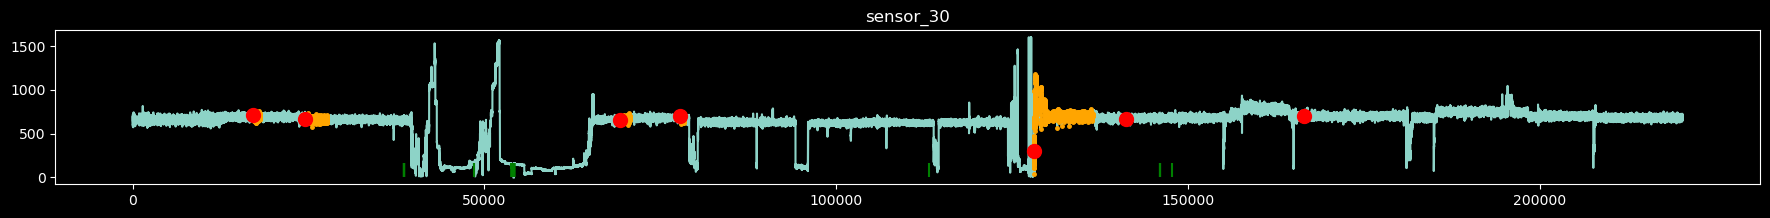

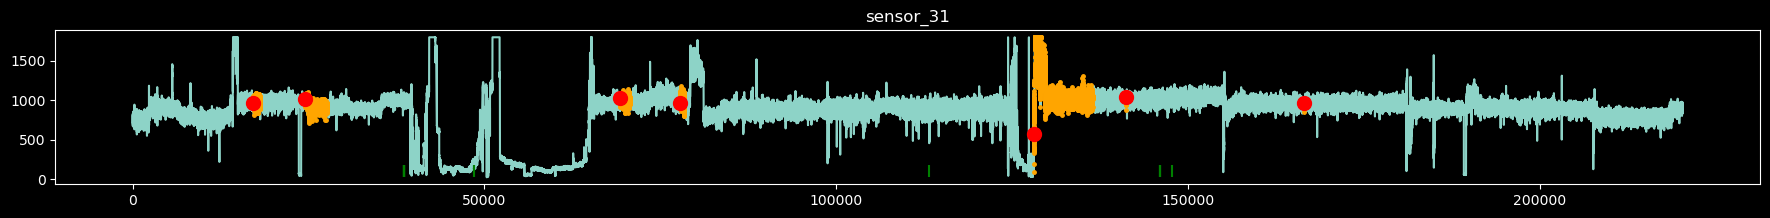

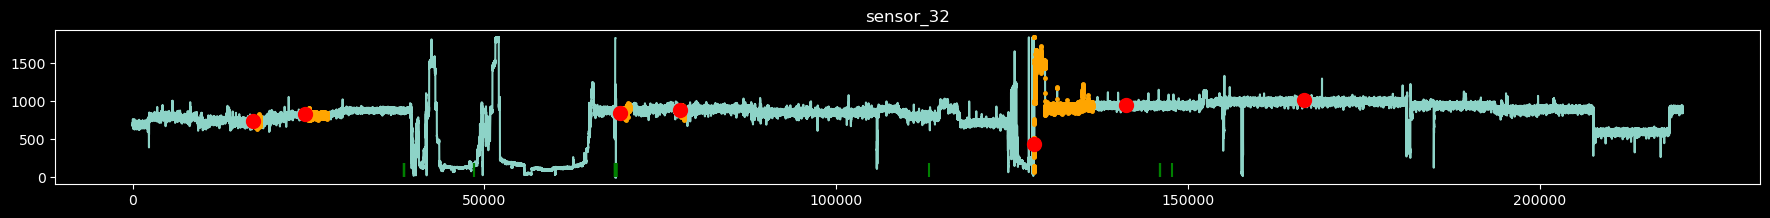

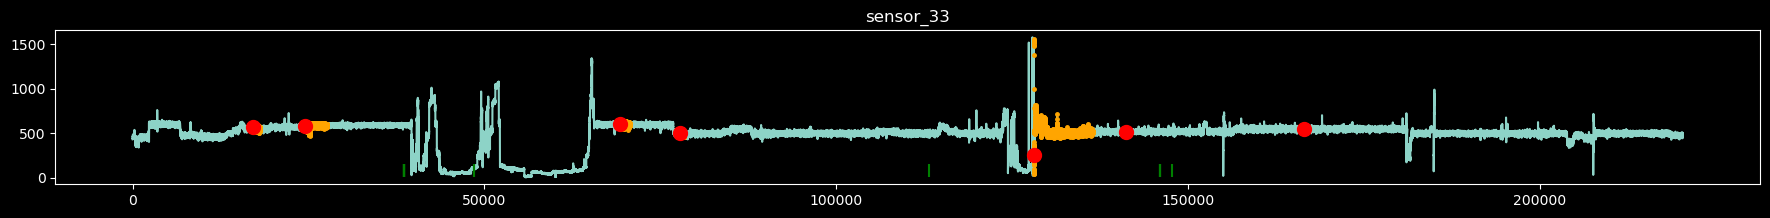

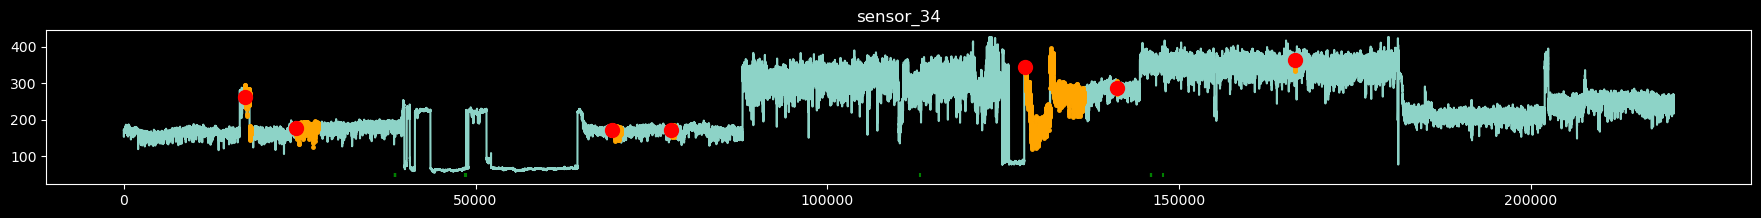

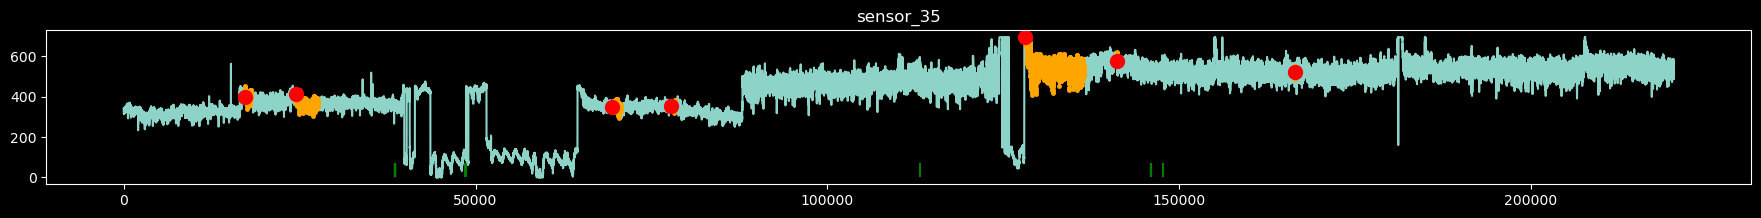

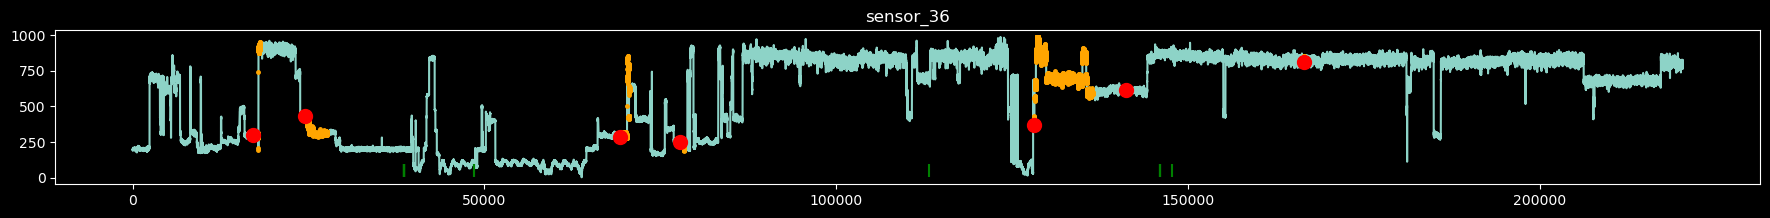

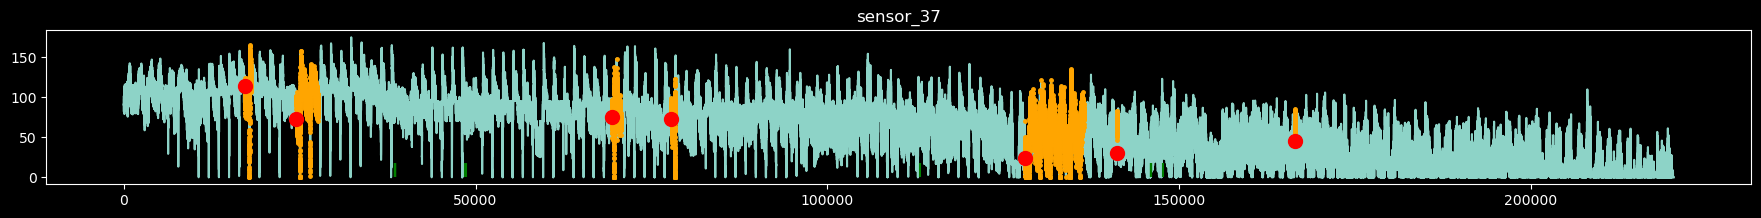

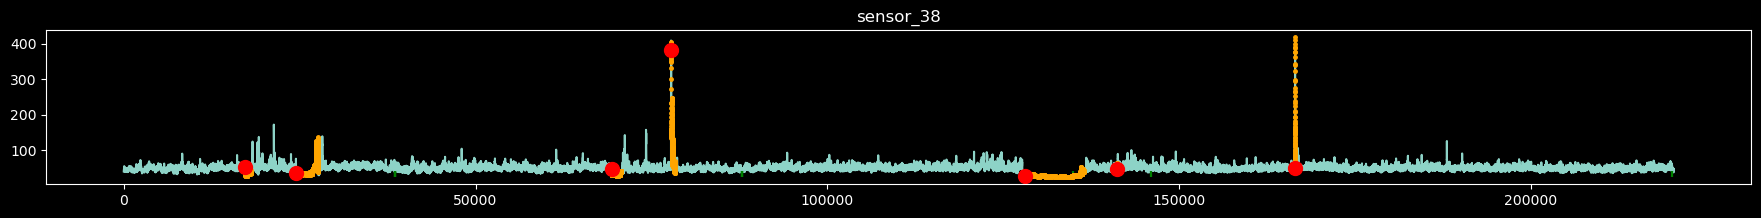

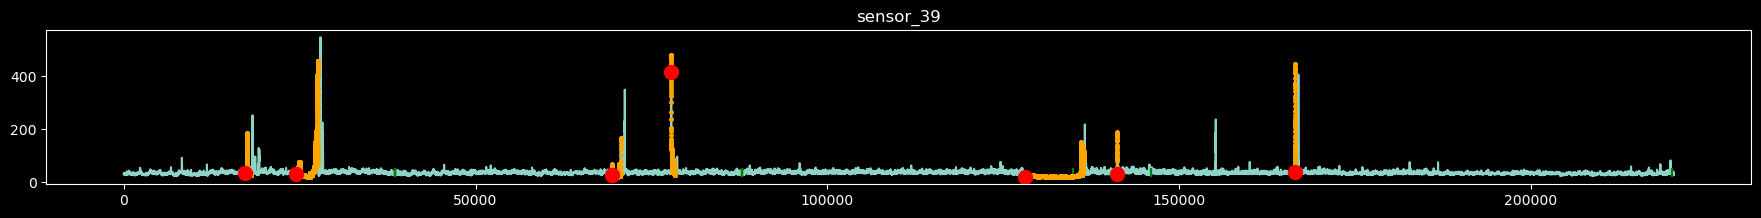

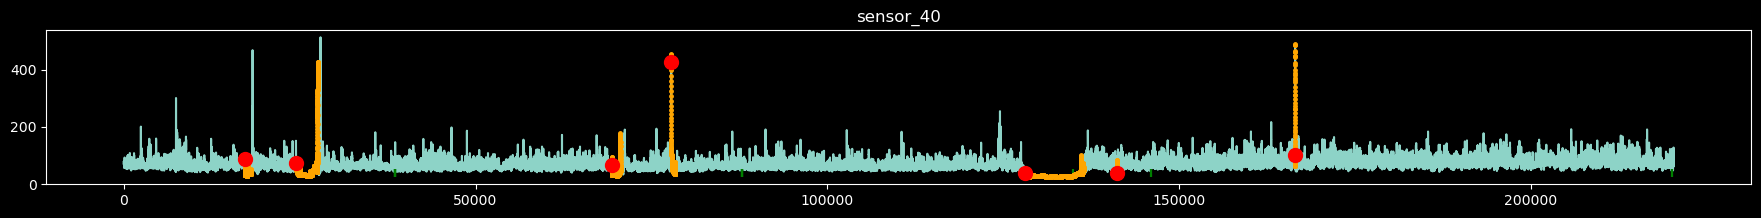

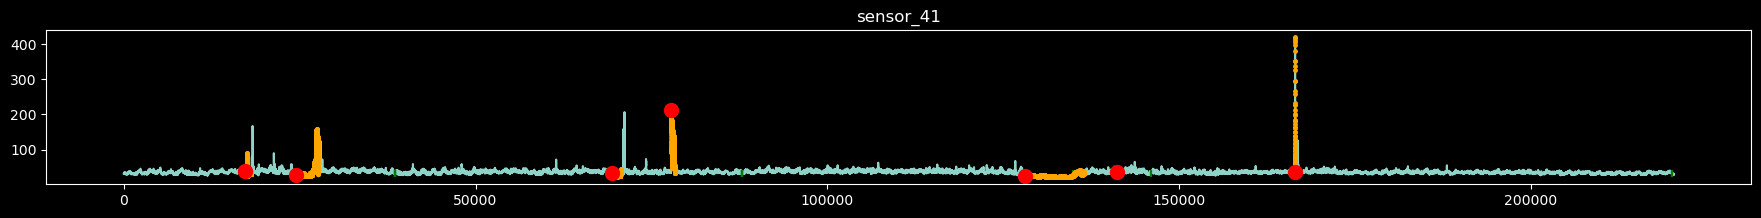

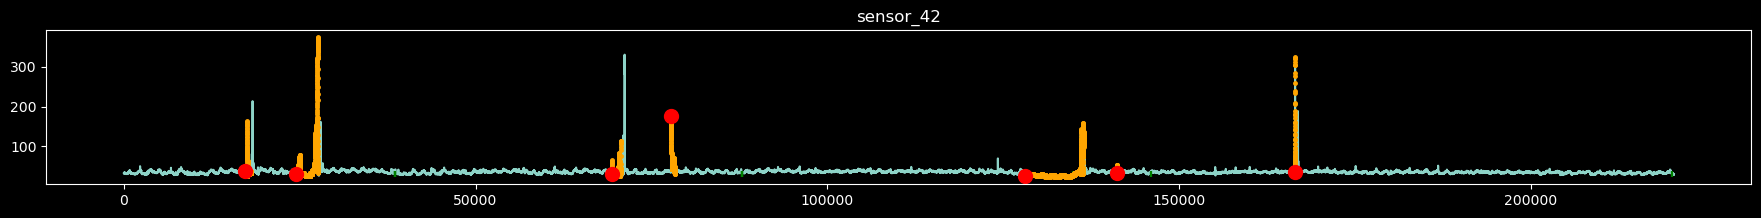

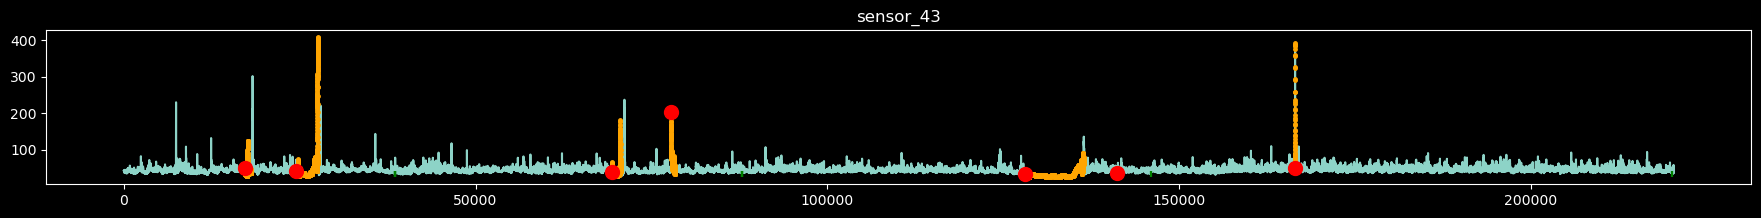

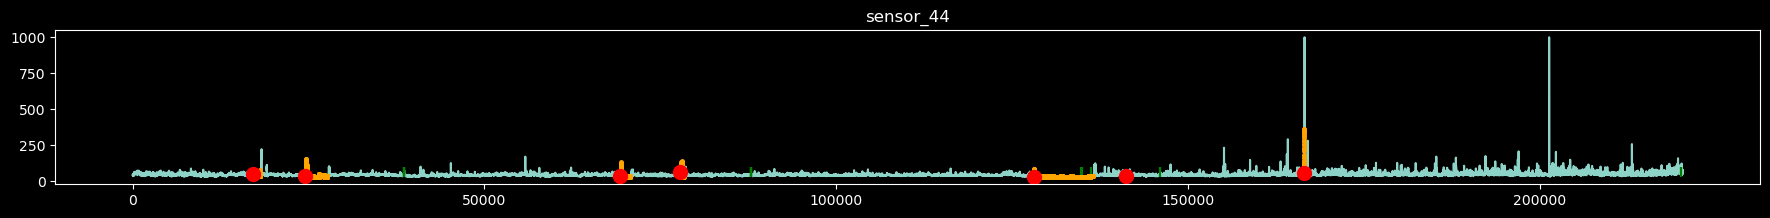

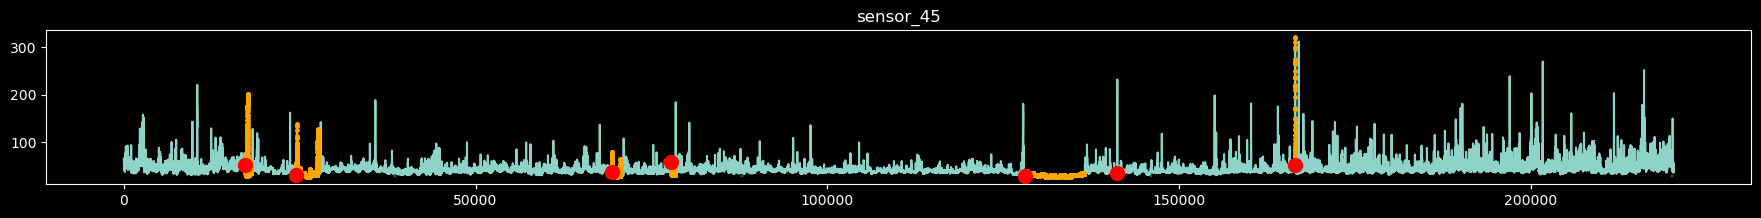

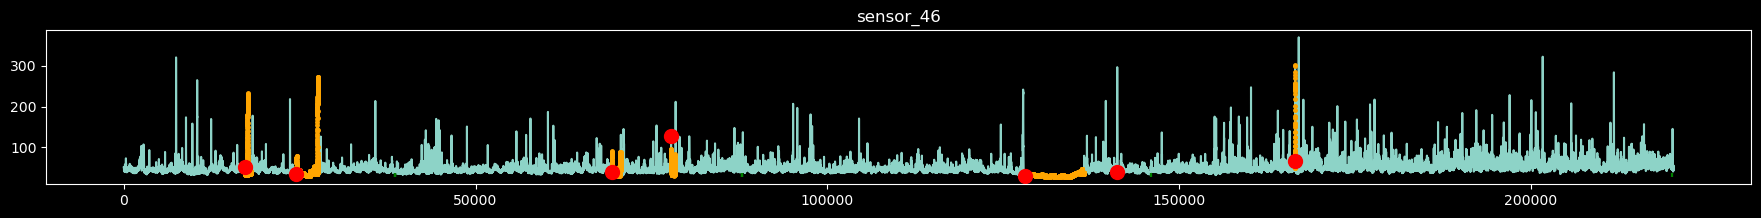

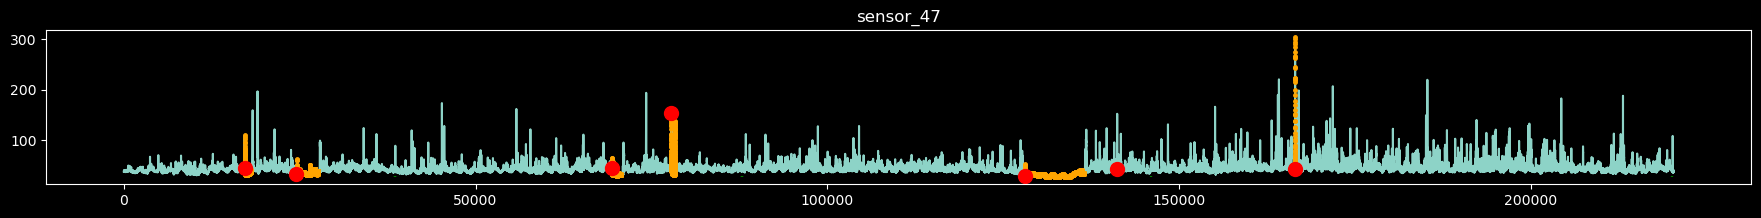

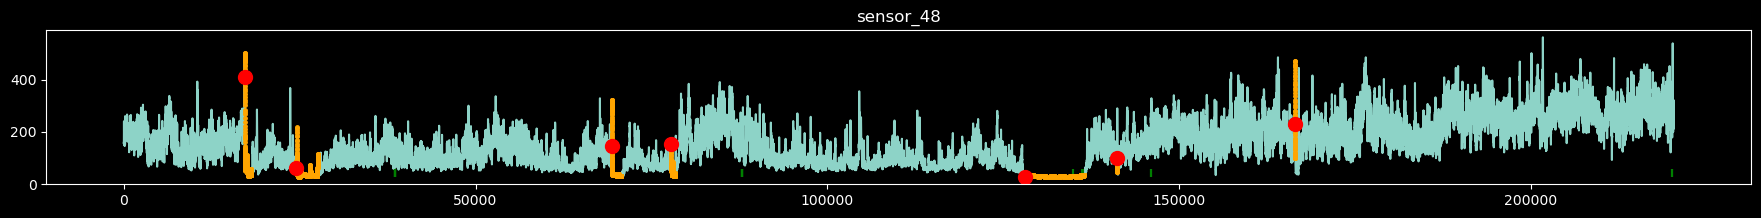

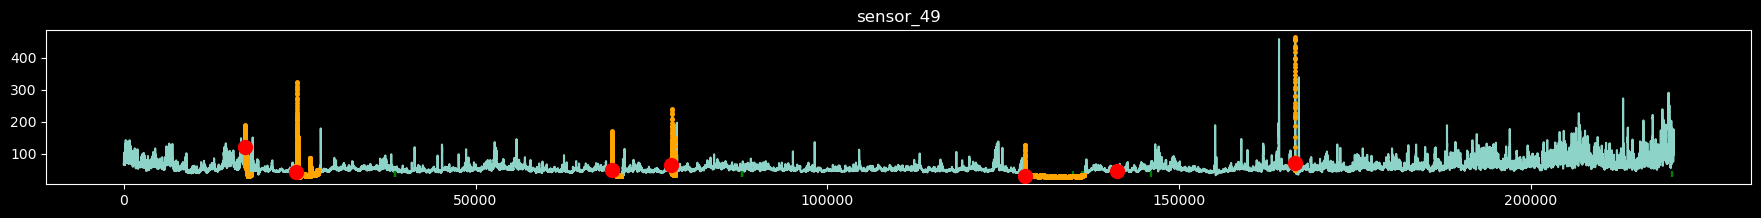

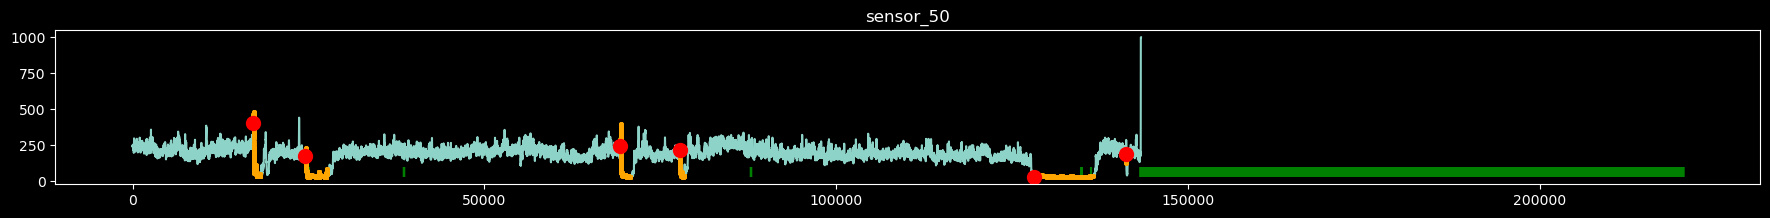

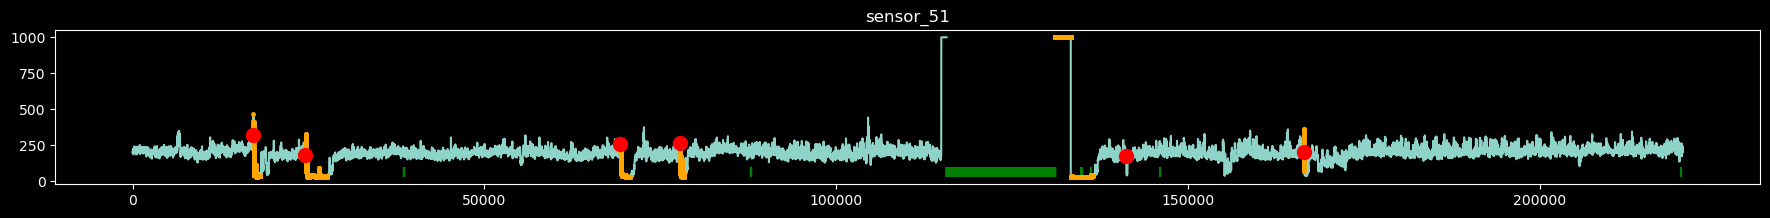

In [8]:
sensors = df.drop('machine_status', axis=1)

broken = df[df['machine_status']=='BROKEN']
recovery = df[df['machine_status']=='RECOVERING']

for sensor in sensors:
    plot = plt.figure(figsize=(22,2))
    
    plot = plt.plot(df[sensor])
    plot = plt.vlines(x=df[df[sensor].isnull()][sensor].index, ymin=min(df[sensor]), ymax=max(df[sensor])/10, colors='green')
    plot = plt.plot(recovery[sensor], linestyle='none', marker='.', color='orange', markersize=5)
    plot = plt.plot(broken[sensor], linestyle='none', marker='o', color='red', markersize=10)
    
    plot = plt.title(sensor)
    plt.show();

Looks like the missing values often correspond to the broken state.

#### Missing values imputation

In [9]:
# linear interpolation
# df = df.interpolate(method='linear')

# forward fill propogation
df = df.fillna(method='ffill')

#### Check skeweness of target class

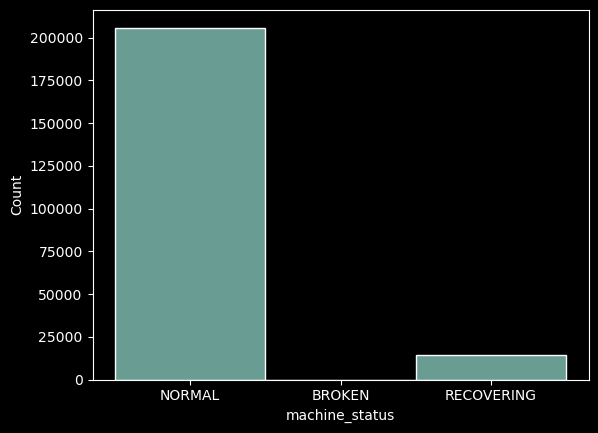

In [10]:
sns.histplot(df.machine_status);

Big skeweness in the target variable may result in a model biased towards one of the classes.<br>
Conversion to numercial values needs to be done anyway. <br>
Potentially, classes could be: 0, 1, 2, but since recovering means the machine is still not normal, we can assign only two classes (0 and 1).

In [11]:
# replacing values
df['machine_status'].replace(['NORMAL', 'RECOVERING', 'BROKEN'], [1, 0, 0], inplace=True)

df.machine_status.value_counts()

1    205836
0     14484
Name: machine_status, dtype: int64

#### Target class as a time-series - when anomaly occurs:

<Axes: >

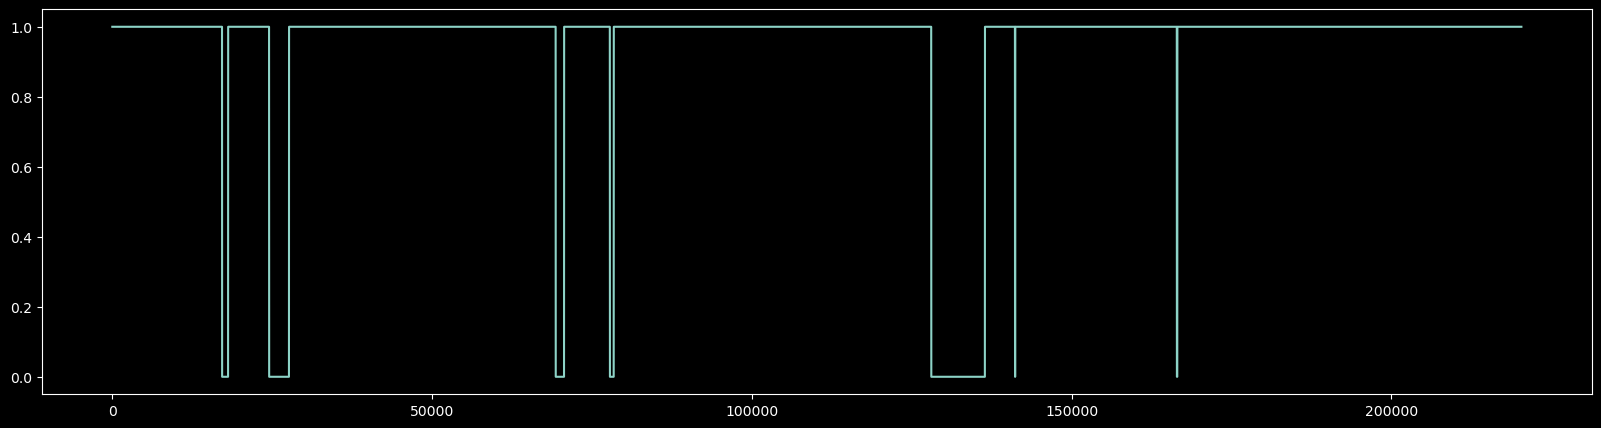

In [12]:
plt.figure(figsize=(20, 5))
df.machine_status.plot()

#### Check for outliers

In [13]:
Q1 = df.quantile(0.25) # lower percentile
Q3 = df.quantile(0.75) # upper percentile

# Inter-Quartile Range
IQR = Q3 - Q1

# Any data point less than the Lower Bound or more than the Upper Bound is considered as an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

is_outlier = ((df < lower_bound) | (df > upper_bound))

outlier_percentage = round(is_outlier.sum()/is_outlier.shape[0], 2)*100
outlier_df = pd.DataFrame(outlier_percentage, columns=['Outlier %'])
outlier_df

Outlier %
sensor_00            11.0
sensor_01             6.0
sensor_02             7.0
sensor_03             5.0
sensor_04            12.0
sensor_05             9.0
sensor_06             7.0
sensor_07             8.0
sensor_08             9.0
sensor_09            27.0
sensor_10             9.0
sensor_11             8.0
sensor_12            13.0
sensor_13             0.0
sensor_14            26.0
sensor_16            22.0
sensor_17            17.0
sensor_18            17.0
sensor_19            26.0
sensor_20            27.0
sensor_21            25.0
sensor_22            13.0
sensor_23            12.0
sensor_24            14.0
sensor_25            13.0
sensor_26            13.0
sensor_27            15.0
sensor_28            13.0
sensor_29            12.0
sensor_30            17.0
sensor_31            15.0
sensor_32            12.0
sensor_33            14.0
sensor_34             0.0
sensor_35             5.0
sensor_36             0.0
sensor_37             0.0
sensor_38             7.0
sensor_39             4.0
sensor_40             5.0
sensor_41             5.0
sensor_42             4.0
sensor_43             5.0
sensor_44             6.0
sensor_45             8.0
sensor_46             6.0
sensor_47             6.0
sensor_48             0.0
sensor_49            10.0
sensor_50             0.0
sensor_51            16.0
machine_status        7.0

#### Lower and upper bounds for outliers

In [14]:
pd.concat([lower_bound, upper_bound], axis=1, keys=['Lower Bound','Upper Bound'])

Lower Bound  Upper Bound
sensor_00          2.298149     2.620832
sensor_01         41.558161    54.231759
sensor_02         46.809895    56.358495
sensor_03         39.127598    49.023441
sensor_04        610.127416   654.108707
sensor_05         53.572989    97.315039
sensor_06         11.483655    16.373695
sensor_07         14.999275    17.285155
sensor_08         14.322915    16.521995
sensor_09         14.847380    15.281380
sensor_10         30.565691    57.603561
sensor_11         22.656625    65.856005
sensor_12         19.302970    44.321630
sensor_13        -15.442941    29.840936
sensor_14        413.762038   425.338138
sensor_16        452.173038   471.580337
sensor_17        435.050612   485.939312
sensor_18          2.237199     2.797964
sensor_19        656.203137   673.712837
sensor_20        394.921588   403.188487
sensor_21        865.466813   892.128112
sensor_22        396.010300   617.201100
sensor_23        741.094750  1300.635950
sensor_24        559.966050   669.793050
sensor_25        609.312238   834.982737
sensor_26        597.559213  1112.032113
sensor_27        316.337863   668.232562
sensor_28        390.746500  1435.913700
sensor_29        181.232062  1081.622163
sensor_30        523.611200   801.388800
sensor_31        625.781150  1194.531150
sensor_32        485.369137  1218.958237
sensor_33        391.659675   653.267875
sensor_34        -44.054412   533.387687
sensor_35         89.584275   792.475075
sensor_36       -534.693912  1660.553187
sensor_37        -64.222984   183.847366
sensor_38         33.463530    65.755210
sensor_39         22.786450    48.828130
sensor_40         27.734380   107.942700
sensor_41         24.739585    45.572905
sensor_42         26.562504    43.229160
sensor_43         29.036455    57.161455
sensor_44         24.160876    57.725698
sensor_45         24.594901    57.002323
sensor_46         24.450226    67.274313
sensor_47         27.777775    57.870375
sensor_48       -102.719875   394.965205
sensor_49         28.211815    80.295135
sensor_50      -1043.547500  2226.128500
sensor_51        116.753550   286.892350
machine_status     1.000000     1.000000

In [15]:
df_no_outliers = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
df_no_outliers

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
9        2.445718  47.178820   53.16840  46.397568   641.7823   74.57428   
10       2.464410  47.482640   53.12500  46.397568   637.7314   76.05148   
11       2.444734  47.916660   53.16840  46.397568   635.6482   74.58654   
12       2.460474  48.263890   53.12500  46.397568   630.0926   76.95988   
13       2.448669  48.437500   53.16840  46.397568   638.6574   75.67310   
...           ...        ...        ...        ...        ...        ...   
212196   2.407350  50.824650   52.12674  46.180550   622.8009   66.77495   
212197   2.402431  50.824650   52.08333  46.180553   637.1528   65.63858   
212242   2.407350  51.041664   52.25694  46.093750   634.2593   70.83183   
212243   2.399479  51.041664   52.30035  46.093750   633.1018   69.81438   
212244   2.404398  51.041664   52.25694  46.093750   631.0186   69.72315   

        sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_43  sensor_44  \
9        13.38252   16.24711   15.61777   15.11863  ...   41.66666  39.062500   
10       13.41146   16.16753   15.65393   15.11863  ...   41.40625  39.351850   
11       13.41146   16.16753   15.84925   15.11863  ...   41.66666  39.351852   
12       13.34635   16.16753   15.73351   15.01013  ...   42.70833  39.351850   
13       13.31742   16.16753   15.84925   15.16927  ...   42.70833  40.509260   
...           ...        ...        ...        ...  ...        ...        ...   
212196   15.15480   16.70284   15.76968   15.08247  ...   46.09375  42.534720   
212197   15.04630   16.65220   15.65393   15.11863  ...   47.91666  42.245370   
212242   15.11863   16.75347   15.53096   15.11863  ...   38.28125  44.560180   
212243   15.08970   16.75347   15.56713   15.11863  ...   38.80208  44.849540   
212244   15.11863   16.65220   15.76968   15.11863  ...   38.80208  46.006940   

        sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  sensor_50  \
9        56.42361   50.63657   39.06250   186.6319   69.73380   246.5278   
10       54.97685   50.92593   39.35185   190.9722   71.18056   250.8681   
11       53.81944   51.21528   39.06250   193.5764   72.33796   253.1829   
12       53.24074   50.92593   39.06250   195.6019   72.33796   253.1829   
13       53.81944   50.63657   39.06250   196.4699   72.91666   252.8935   
...           ...        ...        ...        ...        ...        ...   
212196   46.00694   48.90046   43.69213   162.0370   51.21528  1000.0000   
212197   46.58565   48.03241   42.53472   162.0370   52.08333  1000.0000   
212242   56.71296   43.11343   40.50926   250.8681   67.70834  1000.0000   
212243   55.26620   43.98148   39.64120   247.9745   66.55093  1000.0000   
212244   53.24074   45.42824   39.64120   243.0556   65.10416  1000.0000   

        sensor_51  machine_status  
9        200.8102               1  
10       199.9421               1  
11       200.2315               1  
12       202.2569               1  
13       202.8356               1  
...           ...             ...  
212196   232.9282               1  
212197   231.4815               1  
212242   214.1204               1  
212243   211.8056               1  
212244   209.7801               1  

[58106 rows x 52 columns]

Not too many rows in this case.
In this context it makes sense to keep the outliers as they can act as an indicator for the pump failures.

#### Correlation (Pearson's R)

<Axes: >

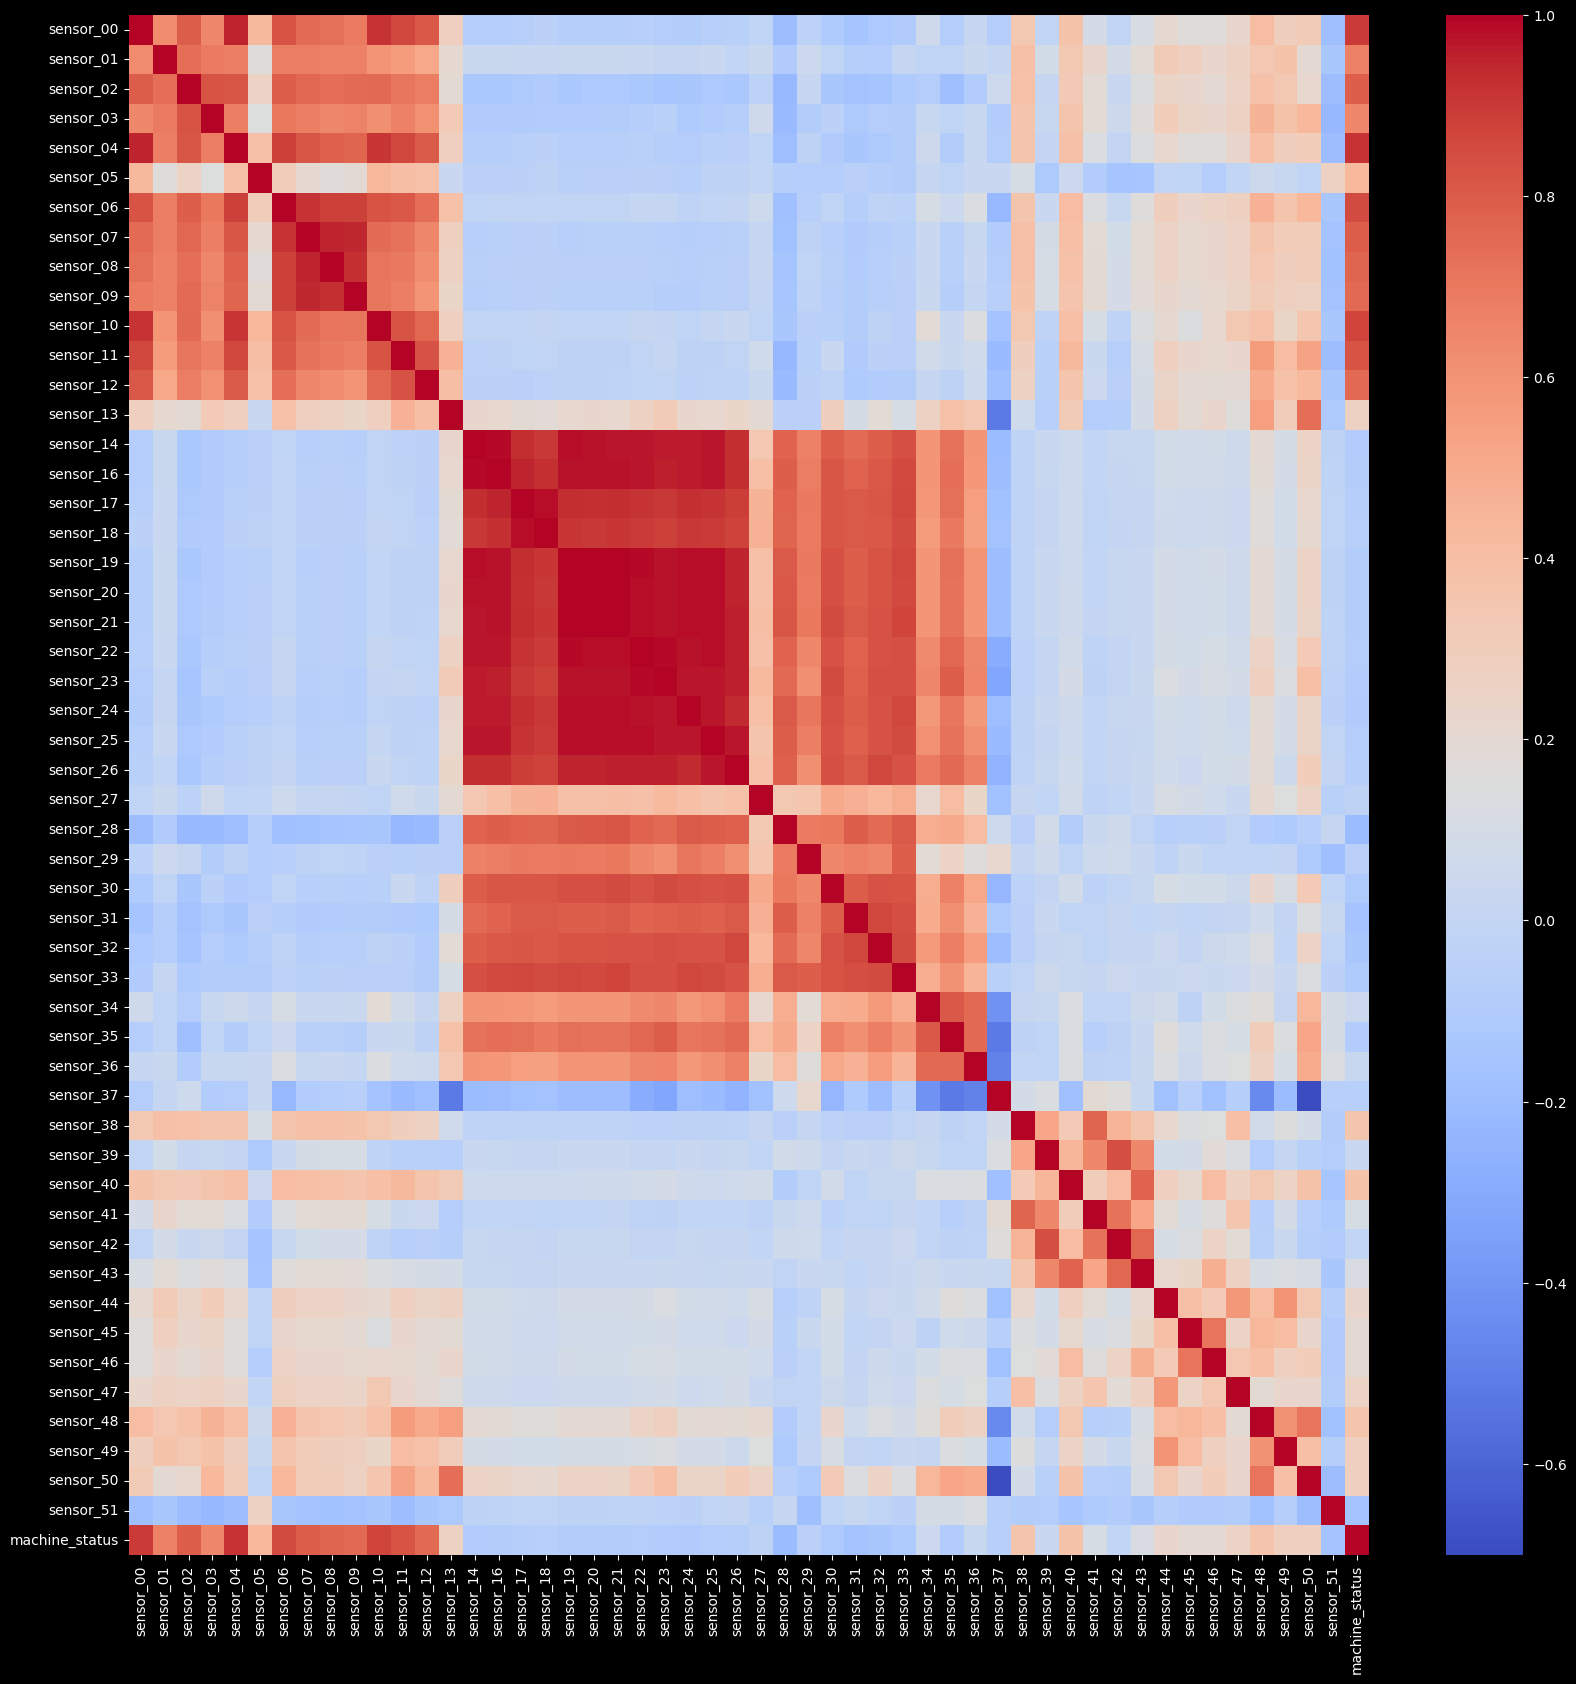

In [16]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='coolwarm')

#### Occam's razor - the principle of parsimony - "the simpler the model, the better"
Some features (e.g. sensors 14-26) are strongly correlated. This increases model complexity and variance.<br>
Some columns (maybe from sensors 15-26) could be removed (this should be investigated).

<Axes: >

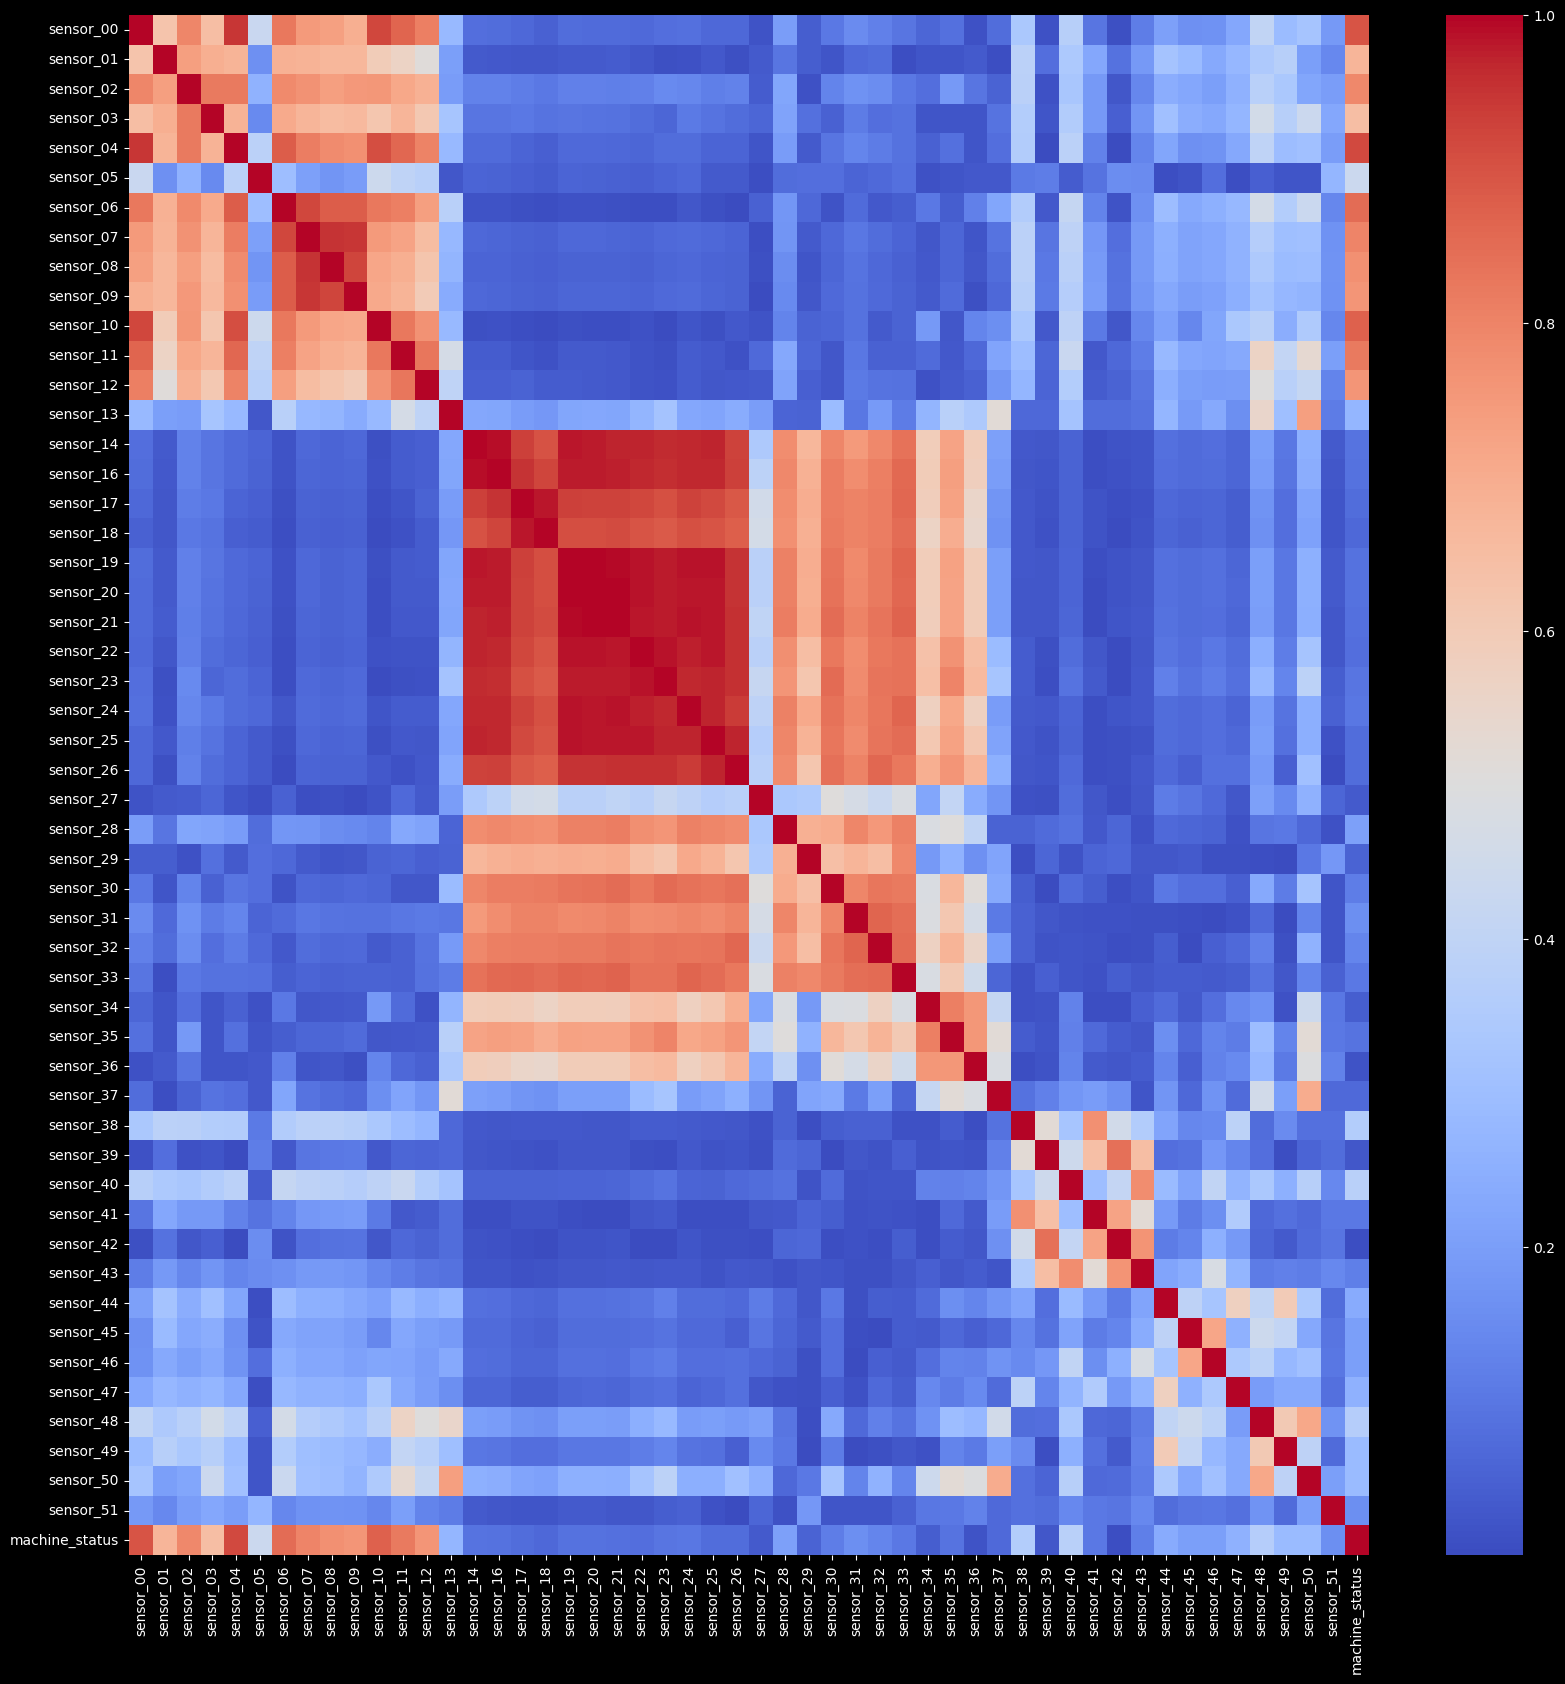

In [17]:
# Create correlation matrix
corr_matrix = df.corr().abs()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm')

Sensors 0-12 look well correlated with the target variable.

#### Features to drop 
Due to high correlation with other variables (redundancy).

We can consider the columns of data representing dimensions on an n-dimensional feature space and the rows of data as points in that space. <br>
This is a useful geometric interpretation of a dataset.<br>

Having a large number of dimensions in the feature space can mean that the volume of that space is very large, and in turn, the points that we have in that space (rows of data) often represent a small and non-representative sample. <br>

This can dramatically impact the performance of machine learning algorithms fit on data with many input features, generally referred to as the “curse of dimensionality.” <br>

Therefore, it is often desirable to reduce the number of input features.

In [18]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7) if column != 'machine_status']

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

print('Dropped: ')
to_drop

Dropped: 


['sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26',
 'sensor_28',
 'sensor_29',
 'sensor_30',
 'sensor_31',
 'sensor_32',
 'sensor_33',
 'sensor_35',
 'sensor_36',
 'sensor_41',
 'sensor_42',
 'sensor_43',
 'sensor_46',
 'sensor_50']

Further column drops

In [19]:
df.drop('sensor_51', axis=1, inplace=True) # poorly correlated with target

#### New correlation matrix
<span style="color: orange;"> .corr does not help that much in time-series data. </span>

<Axes: >

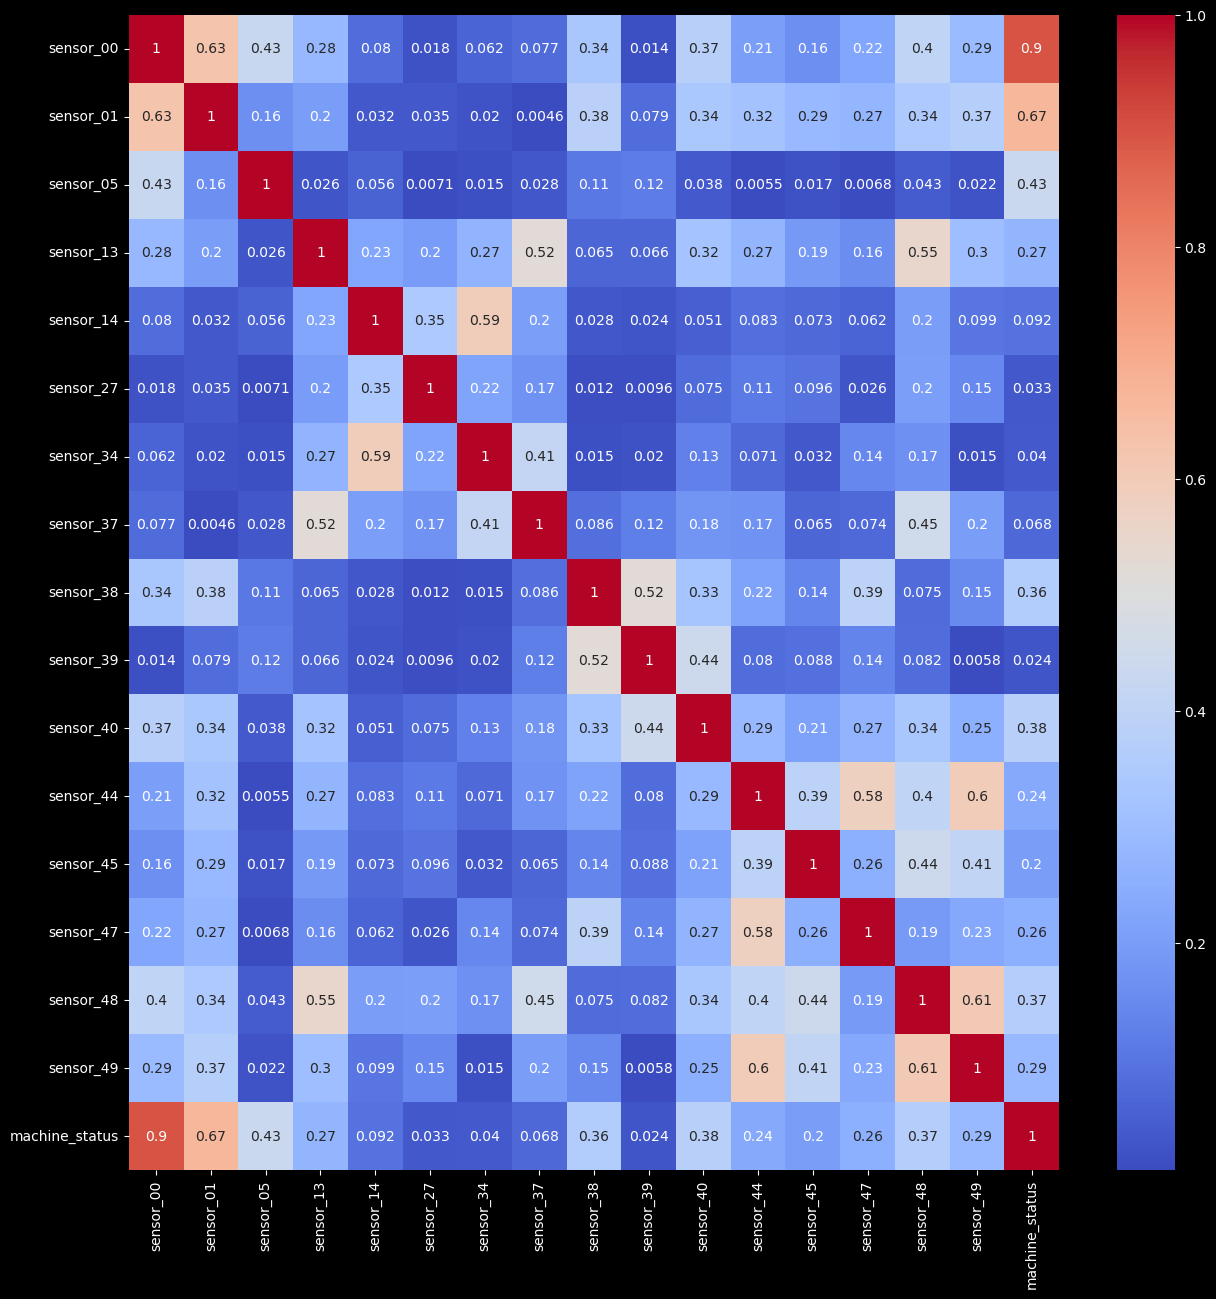

In [20]:
# Create correlation matrix
corr_matrix = df.corr().abs()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

#### Time-series plot (with filled missing data)

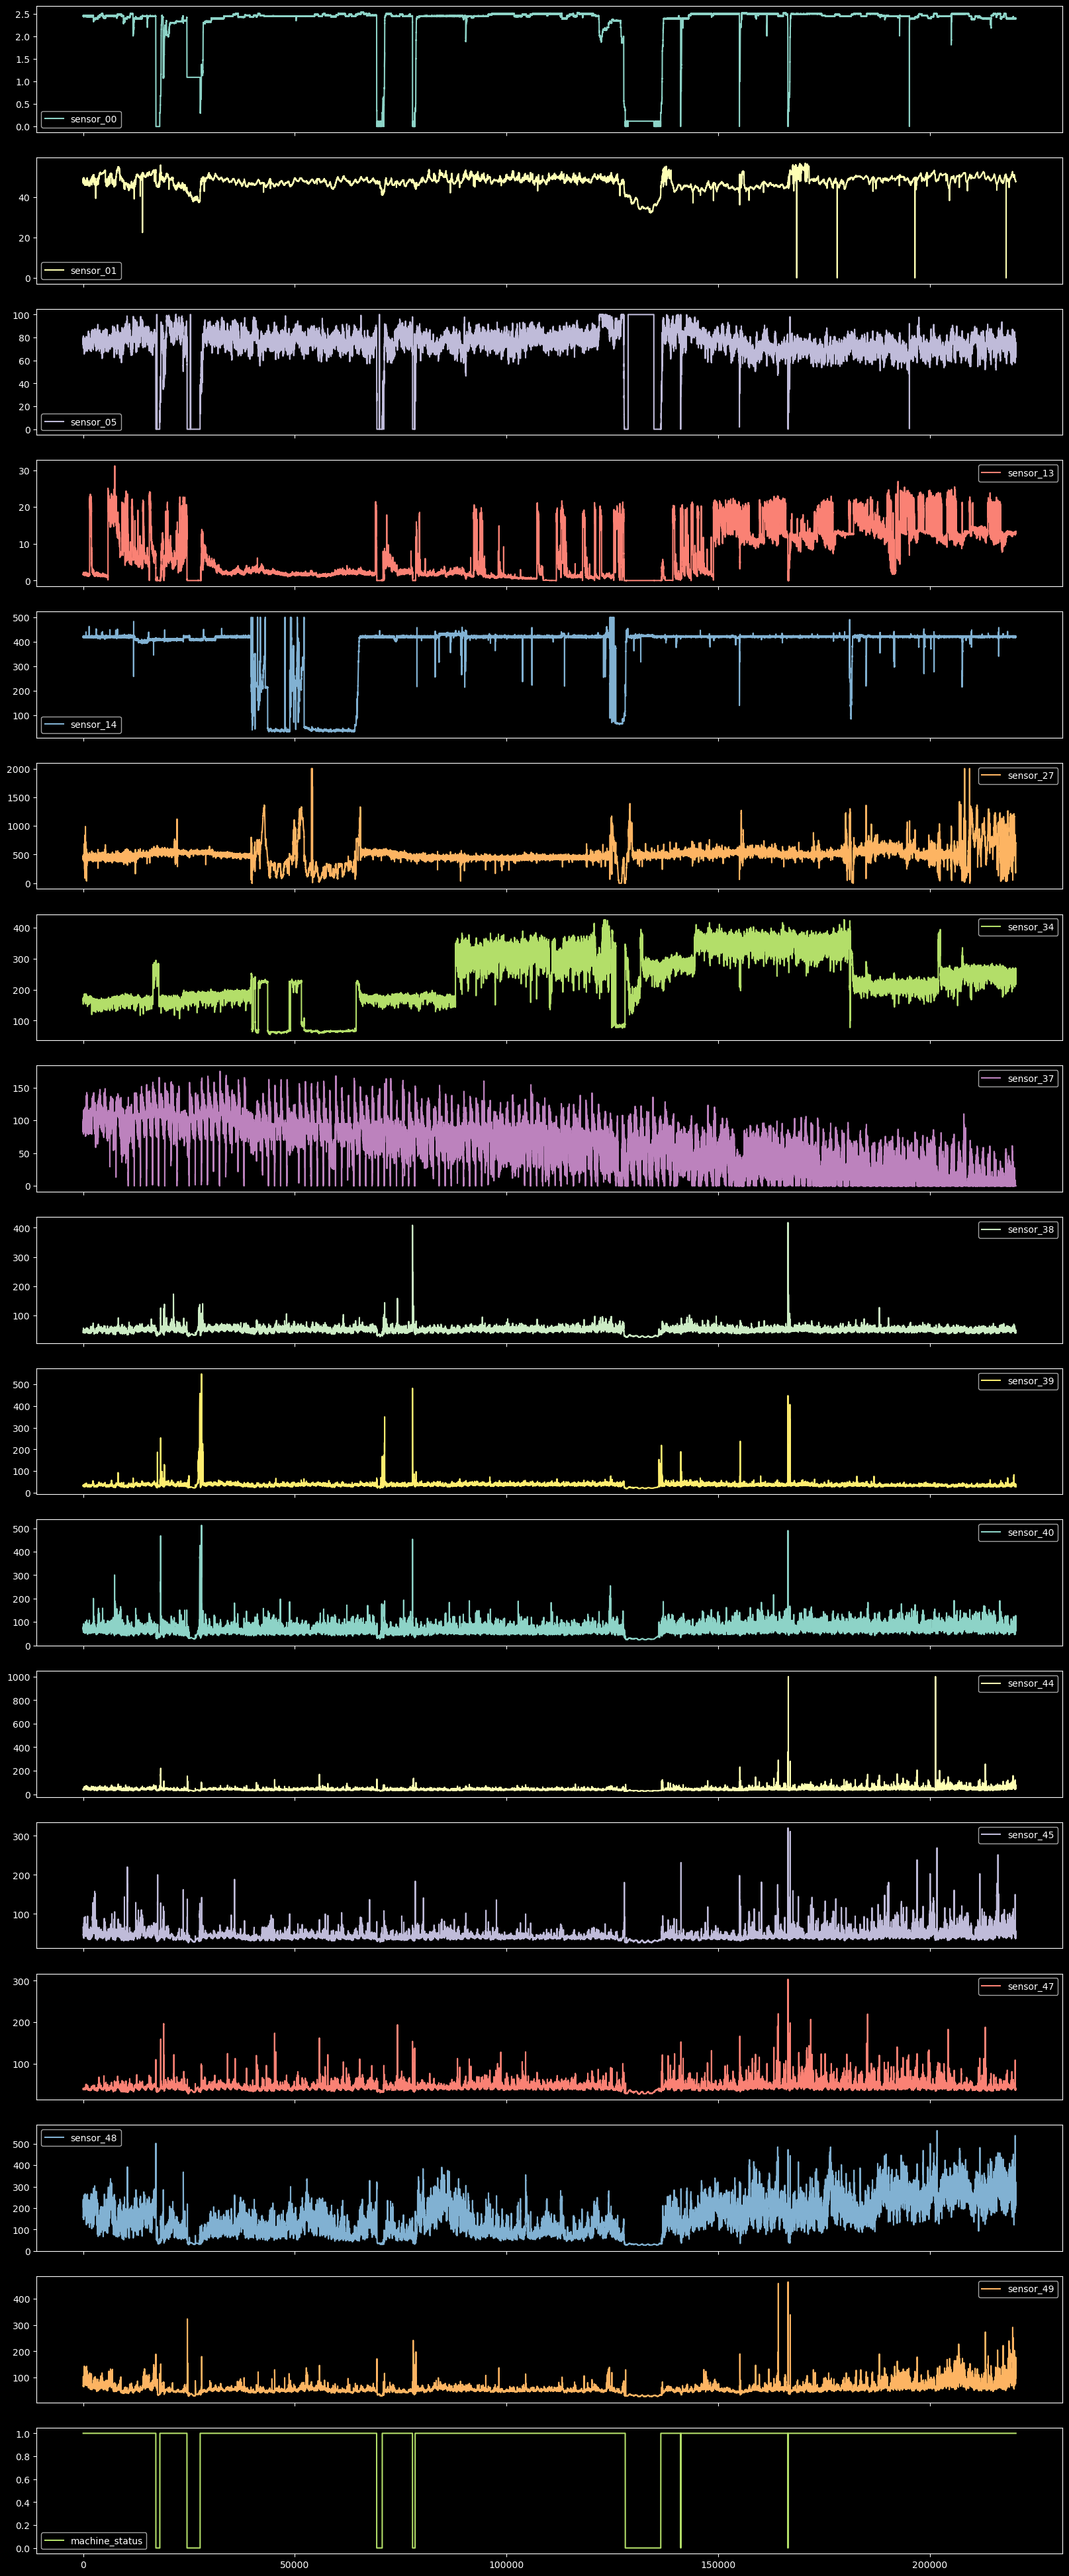

In [21]:
df.plot(subplots =True, sharex = True, figsize = (20,50));

#### Train-Test split

In [22]:
X = df.drop('machine_status', axis=1)
y = df['machine_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False) # do not shuffle

#### Standardize data
Important for PCA. XGB does not require scaling.

In [23]:
scaler = StandardScaler() # standardize features by removing the mean and scaling to unit variance: z = (x - u) / s

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

#### PCA (dimensionality reduction) - finding strong features

Explained variance: [0.55324927 0.22541466]


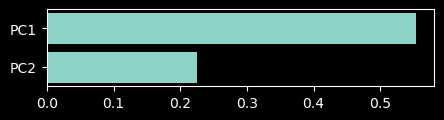

In [24]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
print(f'Explained variance: {explained_variance}')

plt.figure(figsize=(5,1))
plt.barh(y=['PC2', 'PC1'], width=sorted(explained_variance));

In [25]:
# PCA DF
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca

PC1        PC2
0       -62.484907 -27.822340
1       -62.484907 -27.822340
2       -40.518320 -15.835817
3       -23.339082  -4.095353
4       -82.463637 -32.472751
...            ...        ...
220315  206.980411  24.535804
220316  211.967393  27.937354
220317  217.531614  32.659060
220318  220.512576  32.549261
220319  217.726639  31.567385

[220320 rows x 2 columns]

In [26]:
# Correlation of Principal Components with Columns
df_comp = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
df_comp

sensor_00  sensor_01  sensor_05  sensor_13  sensor_14  sensor_27  \
PC1   0.000003   0.001047  -0.001434   0.010911   0.372880   0.889710   
PC2  -0.000101  -0.000635   0.003816  -0.011687  -0.706661   0.448243   

     sensor_34  sensor_37  sensor_38  sensor_39  sensor_40  sensor_44  \
PC1   0.214879  -0.057257   0.000587  -0.000527    0.01335   0.009481   
PC2  -0.526557   0.084704   0.001451  -0.002980   -0.01387  -0.005561   

     sensor_45  sensor_47  sensor_48  sensor_49  
PC1   0.008787   0.003773   0.137994   0.020027  
PC2  -0.001735  -0.009347  -0.121467  -0.006414

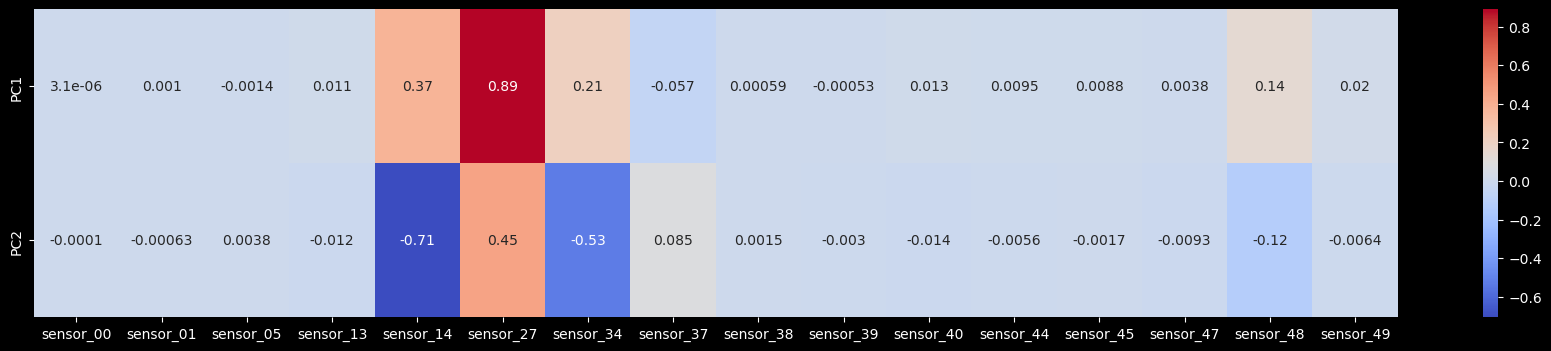

In [27]:
plt.figure(figsize=(22,4))
sns.heatmap(df_comp, cmap='coolwarm', annot=True);

Looks like sensor_27 would be the most important.

#### Select K Best

In [28]:
from sklearn.feature_selection import SelectKBest

# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=5)

# apply feature selection
X_selected = fs.fit_transform(X, y)

# get columns to keep
mask = fs.get_support()
best_features = X.columns[mask]
best_features

Index(['sensor_00', 'sensor_01', 'sensor_05', 'sensor_40', 'sensor_48'], dtype='object')

#### RFE (Recursive Feature Elimination)
RFECV can automatically choose the number of selected features, but takes more time.

In [29]:
# # Recursive Feature Elimination 
# from sklearn.feature_selection import RFE

# model = XGBClassifier()
# rfe = RFE(model, n_features_to_select=5)
# rfe = rfe.fit(X, y)

# # get columns to keep
# best_features = rfe.get_feature_names_out(X.columns)
# print(best_features, '\n')

# # Summarize all RFE features
# for i in range(X.shape[1]):
#     print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

#### Explore Number of Features (~20mins)

In [30]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import cross_val_score

# # get a list of models to evaluate
# def get_models():
#     models = dict()
#     for i in range(2, 10):
#         rfe = RFE(estimator=XGBClassifier(), n_features_to_select=i)
#         model = XGBClassifier()
#         models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
#     return models
 
# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#     return scores

# # get the models to evaluate
# models = get_models()

# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#     scores = evaluate_model(model, X, y)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# # plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.show()

# Machine Learning Model

<span style="color: orange;"> For the moment, using using only classification algorithms. <br>
We will lose the time-series information and make it a pure classification task. </span>

#### Compare models

In [31]:
accuracies = []
f1_scores = []
    
models = [('LR', LogisticRegression()),
          ('SVM', SVC()),
          ('NB', GaussianNB()),
          ('DT', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('XGB', XGBClassifier())]
    
for name, model in models:
    
    print(f'Current model: {model} \n')
    model.fit(X_train, y_train)
    
    #Cross validation:
    scoring_metrics = {'accuracy': make_scorer(accuracy_score), 
                       'f1_score': make_scorer(f1_score)}
    accuracy_results = model_selection.cross_validate(model, X_train, y_train, cv=10, scoring=scoring_metrics)
    
    #Retrieve the scores:
    model_accuracy = accuracy_results['test_accuracy']
    model_f1_score = accuracy_results['test_f1_score']
       
    #Append the lists:
    accuracies.append(model_accuracy)
    f1_scores.append(model_f1_score)

Current model: LogisticRegression() 



/Users/piotr/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Current model: SVC() 

Current model: GaussianNB() 

Current model: DecisionTreeClassifier() 

Current model: RandomForestClassifier() 

Current model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) 



In [32]:
accuracies = np.asarray(accuracies)
f1_scores = np.asarray(f1_scores)

f1_df = pd.DataFrame(np.transpose(f1_scores), columns=['LR', 'SVM', 'NB', 'DT','RF', 'XGB'])
acc_df = pd.DataFrame(np.transpose(accuracies), columns=['LR', 'SVM', 'NB', 'DT','RF', 'XGB'])

#### Accuracy

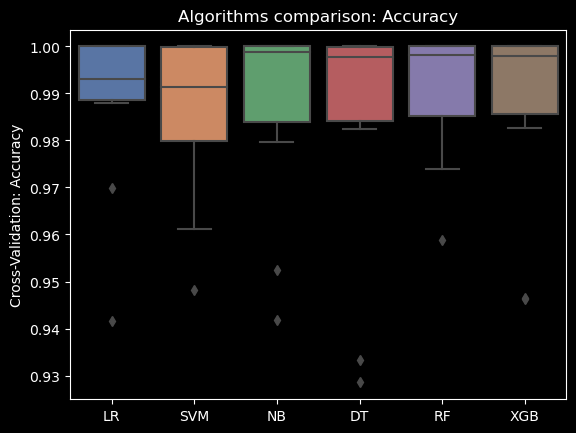

In [33]:
ax = sns.boxplot(data=acc_df, palette='deep')
ax.set_title('Algorithms comparison: Accuracy')
ax.set_ylabel('Cross-Validation: Accuracy');

#### F1-Score

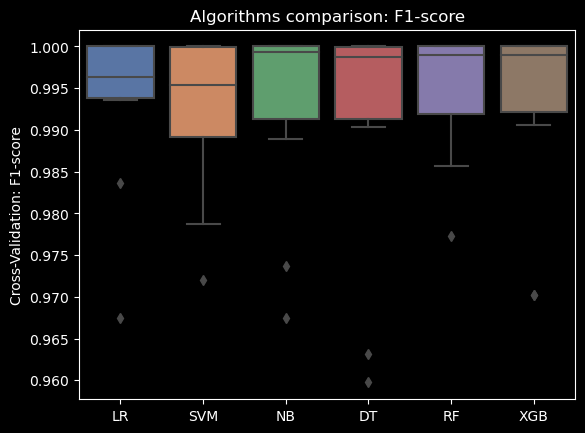

In [34]:
ax = sns.boxplot(data=f1_df, palette='deep')
ax.set_title('Algorithms comparison: F1-score')
ax.set_ylabel('Cross-Validation: F1-score');

#### Gaussian Naive Bayes
XGB - Gradient Boosting Trees seem to overfit

In [35]:
model = GaussianNB()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('Accuracy score: ', accuracy_score(y_test, predictions).round(2))
print('F1 score: ', f1_score(y_test, predictions).round(2))

Accuracy score:  0.99
F1 score:  1.0


In [36]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      4816
           1       0.99      1.00      1.00     83312

    accuracy                           0.99     88128
   macro avg       0.99      0.95      0.97     88128
weighted avg       0.99      0.99      0.99     88128



Text(50.722222222222214, 0.5, 'Actual')

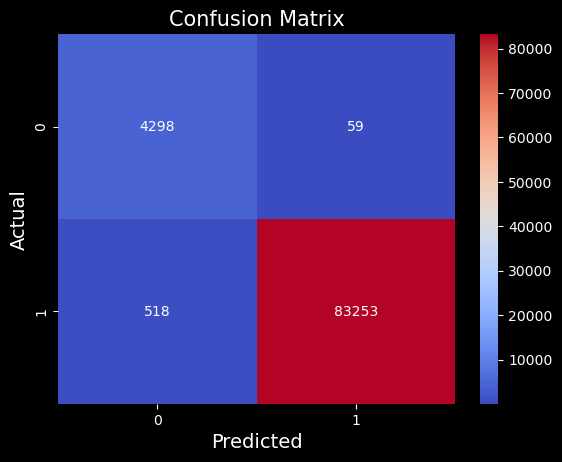

In [37]:
confusion_matrix_test = confusion_matrix(y_test, predictions)

sns.heatmap(confusion_matrix_test, 
            annot=True, 
            fmt="d", 
            cmap="coolwarm")

plt.title("Confusion Matrix",fontsize=15)
plt.xlabel("Predicted",fontsize=14)
plt.ylabel("Actual",fontsize=14)

Imbalanced dataset makes model slighly more inclined to predict normal operating conditions (1s).

#### Get feature importance from XGBoost

In [38]:
# importance = model.feature_importances_

# # summarize feature importance
# for i,v in enumerate(importance):
#     if v > 0.01:
#         print('Feature: %0d, Score: %.5f' % (i,v))

In [39]:
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(3).sort_values(ascending=True).plot(kind='barh')
# plt.title("Top features")
# plt.show()

#### Visualization of the predictions

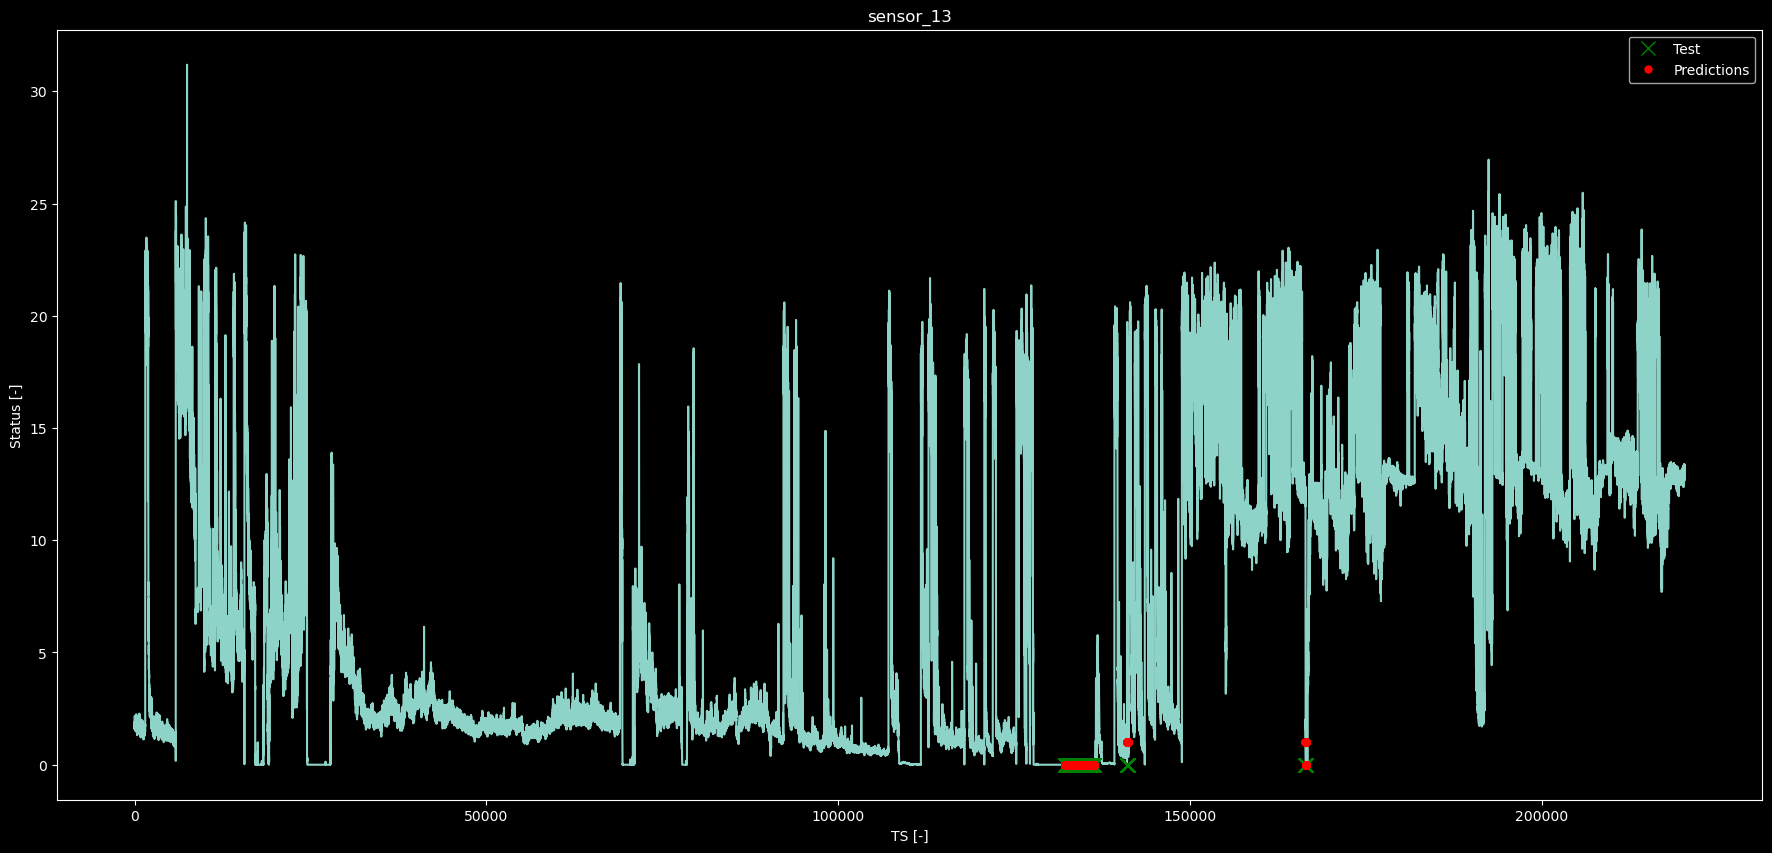

In [40]:
results = pd.DataFrame({'Test': y_test.round(), 'Predictions': predictions.round()})
index_list = y_test[y_test==0].index # get only failed modes
results = results.loc[index_list] # isolate failed modes
results.sort_index(inplace=True)

plt.figure(figsize=(22,10))

plt.plot(X['sensor_13'])
plt.plot(results.index, results['Test'], label='Test', linestyle='none', marker='x', color='green', markersize=10)
plt.plot(results.index, results['Predictions'], label='Predictions', linestyle='none', marker='o', color='red', markersize=5)

plt.title('sensor_13')
plt.xlabel('TS [-]')
plt.ylabel('Status [-]')
plt.legend()
plt.show()

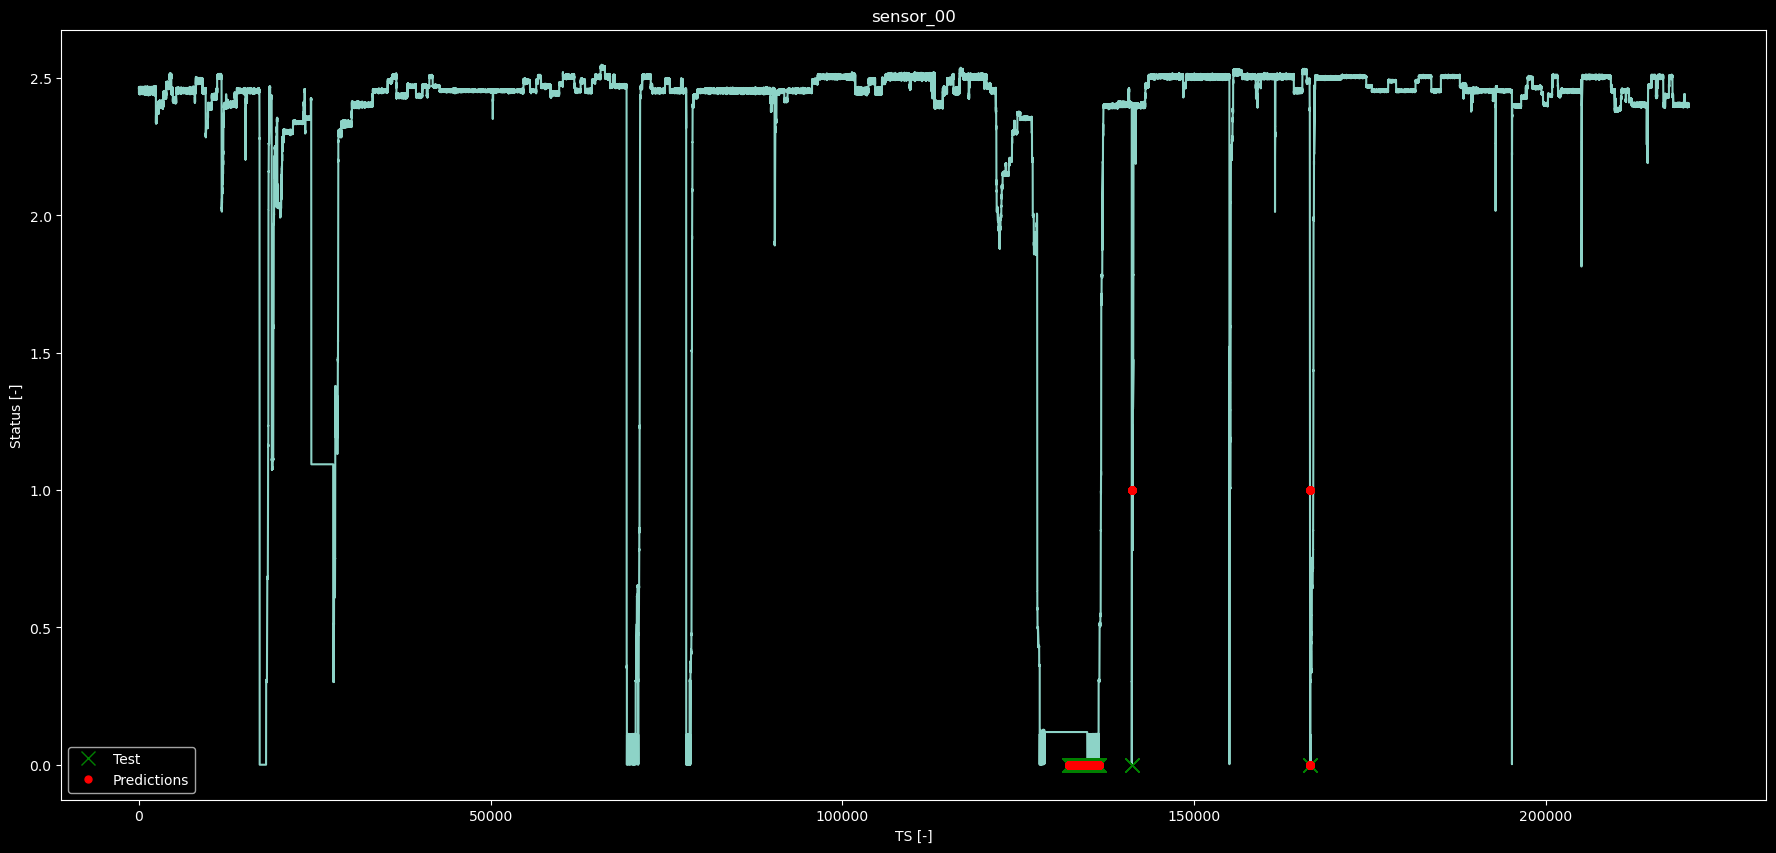

In [41]:
results = pd.DataFrame({'Test': y_test.round(), 'Predictions': predictions.round()})
index_list = y_test[y_test==0].index # get only failed modes
results = results.loc[index_list] # isolate failed modes
results.sort_index(inplace=True)

plt.figure(figsize=(22,10))

plt.plot(X['sensor_00'])
plt.plot(results.index, results['Test'], label='Test', linestyle='none', marker='x', color='green', markersize=10)
plt.plot(results.index, results['Predictions'], label='Predictions', linestyle='none', marker='o', color='red', markersize=5)

plt.title('sensor_00')
plt.xlabel('TS [-]')
plt.ylabel('Status [-]')
plt.legend()
plt.show()

From the predicted failure points, it looks like sometimes we predict failure earlier, which is a good thing, but this should be investigated and improved.

#### Bad predictions to investigate (just failure perspective - 0s)

In [42]:
results[results.Predictions != results.Test] # results DF has in this case isolated only failed (0) modes (too many 1s)

Test  Predictions
141131     0            1
141132     0            1
141133     0            1
141134     0            1
141135     0            1
141136     0            1
141137     0            1
141138     0            1
141139     0            1
141140     0            1
141141     0            1
141142     0            1
141143     0            1
141144     0            1
141145     0            1
141146     0            1
141147     0            1
141148     0            1
141149     0            1
141150     0            1
141151     0            1
141152     0            1
141153     0            1
141154     0            1
141155     0            1
141156     0            1
141157     0            1
141158     0            1
141159     0            1
141160     0            1
141161     0            1
141162     0            1
141163     0            1
141164     0            1
141165     0            1
141166     0            1
141167     0            1
141168     0            1
141169     0            1
141170     0            1
141171     0            1
141172     0            1
166440     0            1
166441     0            1
166442     0            1
166443     0            1
166444     0            1
166445     0            1
166446     0            1
166447     0            1
166448     0            1
166449     0            1
166450     0            1
166451     0            1
166452     0            1
166453     0            1
166454     0            1
166455     0            1
166456     0            1

# Next steps

1. Closer look at bad predictions and what caused them. Potentially more strict feature selection. More tinkering with PCA could be a start. 
2. It would be good to investigate why different feature selection methods yield different columns.
3. Compare with LSTM model, other models and of course with other hyper-parameters. Check also KNN with a proper K exploration. Also grid search CV.
4. Use different imputation, maybe KNN (with scaling, because it is distant-based), or Multivariate Imputation by Chained Equation — MICE.
5. Closer look at the outliers and which to remove.
6. Try to predict failure timestamps as early as possible, based on past behaviour.
7. Down-sampling of the data to mitigate skeweness.
8. Look at the problem as un-supervised learning task and create clusters (just 0s and 1s or also including 'Recovery' modes).
9. Check the model on different pipe data, or even different plant and check the predictive power.
10. Think about productionalization of the architecture in real environment, maybe also using Infrastructure as Code (IaC).



# Deep Learning - LSTM

In [43]:
import sys
import tensorflow.keras
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")

print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0

print()
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0
Keras Version: 2.9.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1

GPU is available


In [44]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [45]:
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [46]:
model = Sequential()

model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.05))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-09 16:55:20.861962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-09 16:55:20.862080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2023-03-09 16:55:21.236711: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-09 16:55:21.848352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 16:55:21.997305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 16:55:22.175961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 16:55:29.967341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 16:55:30.022946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1033/1033 - 11s - loss: 0.1069 - val_loss: 0.0899 - 11s/epoch - 11ms/step
Epoch 2/30
1033/1033 - 10s - loss: 0.0218 - val_loss: 0.0334 - 10s/epoch - 9ms/step
Epoch 3/30
1033/1033 - 10s - loss: 0.0150 - val_loss: 0.0166 - 10s/epoch - 9ms/step
Epoch 4/30
1033/1033 - 10s - loss: 0.0122 - val_loss: 0.0119 - 10s/epoch - 9ms/step
Epoch 5/30
1033/1033 - 10s - loss: 0.0107 - val_loss: 0.0102 - 10s/epoch - 9ms/step
Epoch 6/30
1033/1033 - 10s - loss: 0.0096 - val_loss: 0.0091 - 10s/epoch - 9ms/step
Epoch 7/30
1033/1033 - 10s - loss: 0.0088 - val_loss: 0.0081 - 10s/epoch - 9ms/step
Epoch 8/30
1033/1033 - 10s - loss: 0.0081 - val_loss: 0.0072 - 10s/epoch - 9ms/step
Epoch 9/30
1033/1033 - 10s - loss: 0.0075 - val_loss: 0.0064 - 10s/epoch - 9ms/step
Epoch 10/30
1033/1033 - 10s - loss: 0.0070 - val_loss: 0.0060 - 10s/epoch - 9ms/step
Epoch 11/30
1033/1033 - 10s - loss: 0.0066 - val_loss: 0.0054 - 10s/epoch - 9ms/step
Epoch 12/30
1033/1033 - 10s - loss: 0.0063 - val_loss: 0.0052 - 10s/epoch - 9ms/step

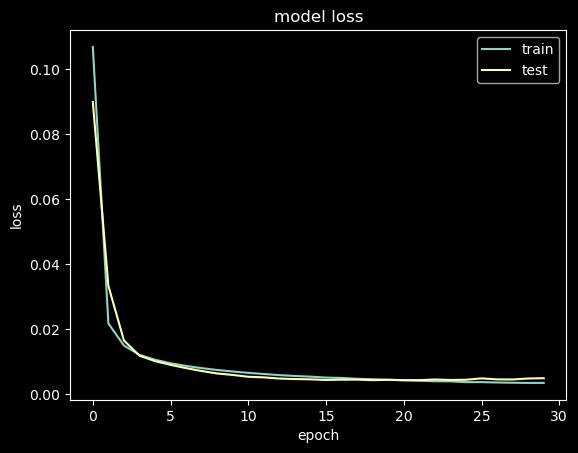

In [47]:
batch_size = 128

# Network fitting
history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    verbose=2, 
                    shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### Predictions

In [48]:
predictions = model.predict(X_test).ravel().round(decimals=0)

  20/2754 [..............................] - ETA: 7s   

2023-03-09 17:00:19.975221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-09 17:00:20.031579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2754/2754 [==============================] - 8s 3ms/step


In [49]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

        -0.0       0.99      0.95      0.97      4531
         1.0       1.00      1.00      1.00     83597

    accuracy                           1.00     88128
   macro avg       0.99      0.97      0.98     88128
weighted avg       1.00      1.00      1.00     88128



Text(50.722222222222214, 0.5, 'Actual')

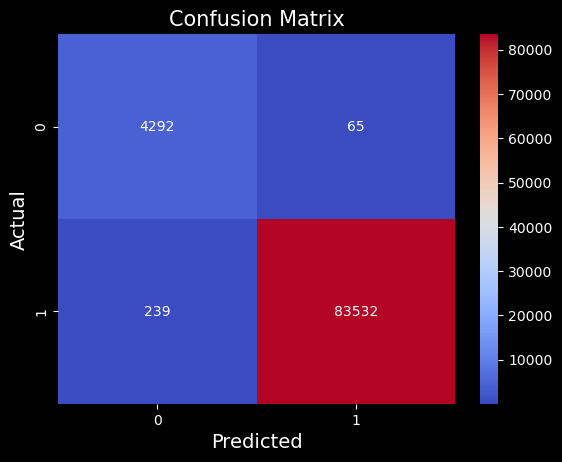

In [50]:
confusion_matrix_test = confusion_matrix(y_test, predictions)

sns.heatmap(confusion_matrix_test, 
            annot=True, 
            fmt="d", 
            cmap="coolwarm")

plt.title("Confusion Matrix",fontsize=15)
plt.xlabel("Predicted",fontsize=14)
plt.ylabel("Actual",fontsize=14)

#### Visualisation

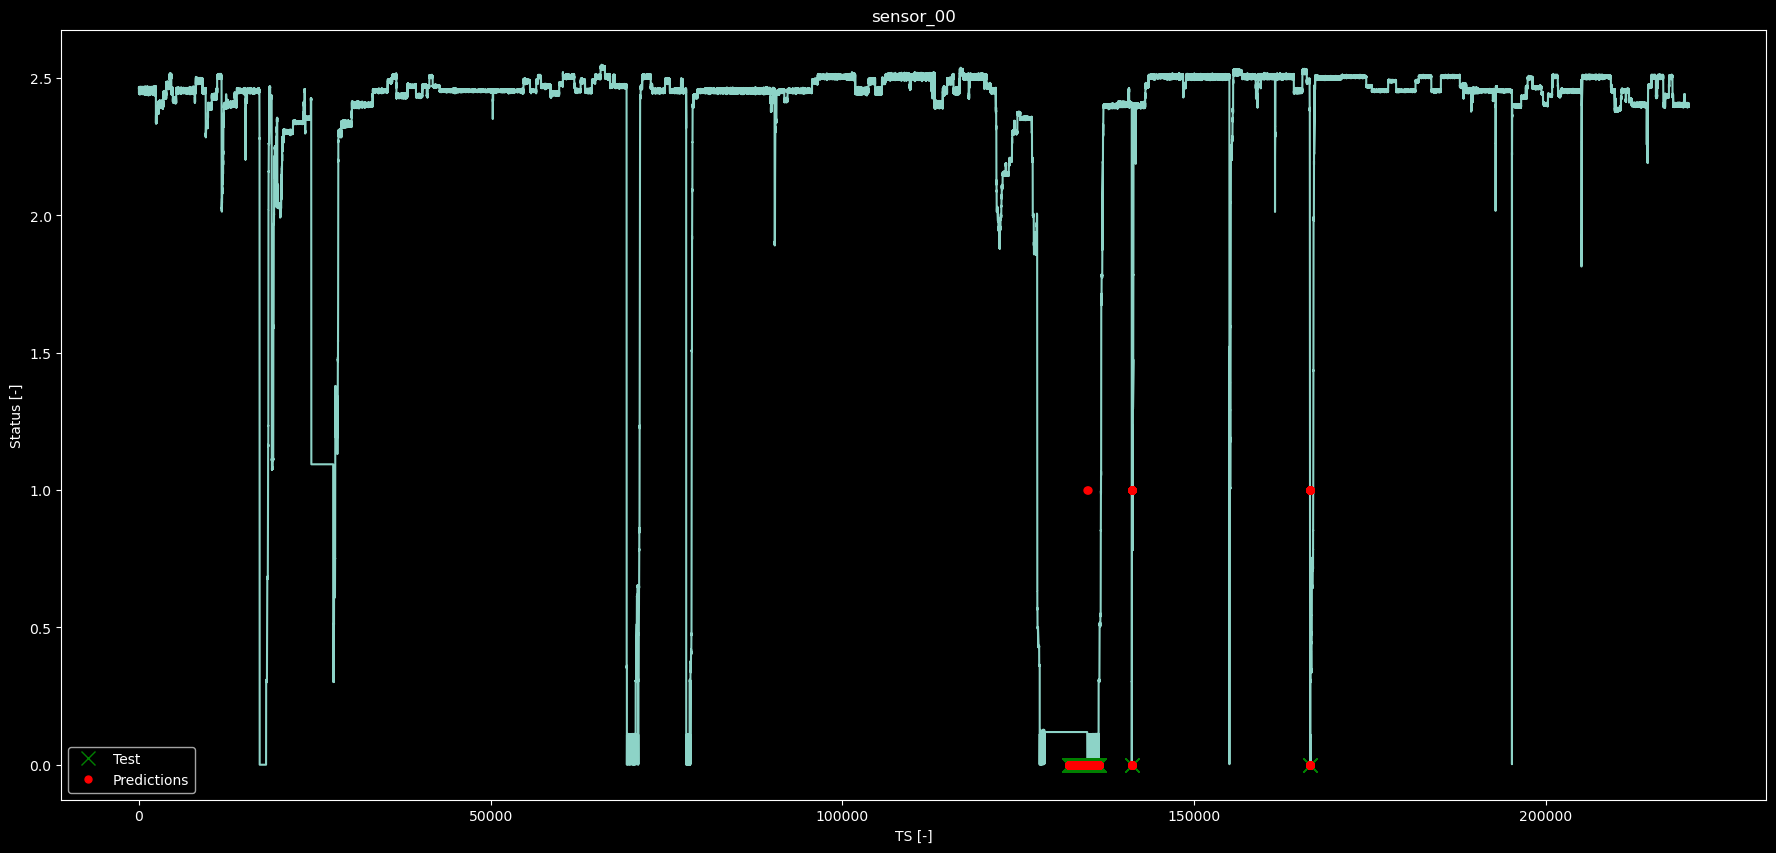

In [51]:
results = pd.DataFrame({'Test': y_test.round(), 'Predictions': predictions.round()})
index_list = y_test[y_test==0].index # get only failed modes
results = results.loc[index_list] # isolate failed modes
results.sort_index(inplace=True)

plt.figure(figsize=(22,10))

plt.plot(X['sensor_00'])
plt.plot(results.index, results['Test'], label='Test', linestyle='none', marker='x', color='green', markersize=10)
plt.plot(results.index, results['Predictions'], label='Predictions', linestyle='none', marker='o', color='red', markersize=5)

plt.title('sensor_00')
plt.xlabel('TS [-]')
plt.ylabel('Status [-]')
plt.legend()
plt.show()